In comparison to other MOO algos this algo performs badly. Changes to do:
1. seek for better minimizer with less evaluations -> bayesian optimization!
2. apply this type of moo to surrogate 

## Import necessary modules

In [1]:
import os 
import numpy as np
import random
from pymoo.indicators.hv import Hypervolume
from scipy.optimize import differential_evolution

In [2]:
os.chdir('/Users/nicopalm/Documents/Projects/helper')
from plotting.notebook_plotting import *

In [3]:
os.chdir('/Users/nicopalm/Documents/Projects/multi-objective-optimization/src/')

In [4]:
from interfaces.function import Function
from weight_functions.scalar import Scalar
from weight_functions.potence import Potence
from minimizers.differential_evolution import DifferentialEvolution

## Define the underlying function

In [5]:
input_dimensions = 10
output_dimensions = 2
starting_point = np.ones(input_dimensions)
bounds = tuple([(0, 1) for _ in range(input_dimensions)])

In [6]:
# Define the function
from pymoo.factory import get_problem
from pymoo.visualization.scatter import Scatter
from pymoo.factory import get_performance_indicator

In [7]:
problem = get_problem("dtlz2",
                        n_var=input_dimensions,
                        n_obj=output_dimensions)

In [8]:
max_iter = 50
class ExampleFunction(Function):
    def __call__(self, x):
        if len(self._evaluations)<max_iter:
            self._evaluations.append([
                x,
                problem.evaluate(x)
            ])
        return problem.evaluate(x)

In [9]:
# Initialiaze the function
function = ExampleFunction()

## Visualize the function

In [10]:
number_sample_points = 1000
sample_points = [
    np.array([random.uniform(bound[0], bound[1]) for bound in bounds])
    for _ in range(number_sample_points)
]
evaluations_sample_points = [function(point) for point in sample_points]

In [11]:
# Plot function
class ExampleDataFunction(DataFunction):
    def __init__(self, index_fixed):
        self.index_fixed = index_fixed
        self.title = ''

    def __call__(self, index):
        x_dots = [
            point[self.index_fixed] for point in evaluations_sample_points
        ]
        y_dots = [point[index] for point in evaluations_sample_points]
        return [dot_scatter(x_dots=x_dots, y_dots=y_dots)]

In [12]:
interactive_plot(data_function=ExampleDataFunction(index_fixed=0),indices=(0,output_dimensions-1,1),start_index=1)

interactive(children=(IntSlider(value=1, description='index', max=1), Output()), _dom_classes=('widget-interac…

### Visualization of the function/manual tuning of parameter

In [13]:
from ipywidgets import interact

In [14]:
x0 = 0.5*np.ones(input_dimensions)

y0 = function(x0)

## Calculate the pareto optima

In [15]:
# Define the weight function
#weight_function = Scalar(theta=np.ones(output_dimensions))
weight_function = Potence(potence=2 * np.ones(output_dimensions))

In [16]:
# Define the minimizer
#minimizer = SLSQP(starting_point=starting_point)
minimizer = DifferentialEvolution(starting_point=starting_point, bounds=bounds,max_iter = 1)

In [17]:

function._evaluations = [
]  # reset the evaluations (used to approximate the image of the function)
minimizer(lambda x: weight_function(function(x)))

differential_evolution step 1: f(x)= 1.40472


array([0.99455141, 0.49999978, 0.49999989, 0.49999967, 0.4999999 ,
       0.50000014, 0.50000012, 0.49999989, 0.49999967, 0.50000015])

## Plot evaluations of sampled points

In [18]:
# Plot function
class ExampleDataFunction(DataFunction):
    def __init__(self, index_fixed):
        self.index_fixed = index_fixed
        self.title = ''

    def __call__(self, index):
        x_dots_eval = [
            point[1][self.index_fixed] for point in function.evaluations
        ]
        y_dots_eval = [point[1][index] for point in function.evaluations]
        return [
            dot_scatter(x_dots=x_dots_eval, y_dots=y_dots_eval),
            dot_scatter(
                x_dots=[function(minimizer.result.x)[self.index_fixed]],
                y_dots=[function(minimizer.result.x)[index]],
                name_dots='Pareto optimum found')
        ]

In [19]:
interactive_plot(data_function=ExampleDataFunction(index_fixed=0),
                 indices=(0, output_dimensions-1, 1),
                 start_index=1)

interactive(children=(IntSlider(value=1, description='index', max=1), Output()), _dom_classes=('widget-interac…

## Look at the results

In [20]:
#function.evaluations

In [21]:
minimizer.result

     fun: 1.0000000000007183
     jac: array([ 2.22044604e-08, -8.43769499e-07, -3.99680289e-07, -1.28785871e-06,
       -3.55271368e-07,  6.21724891e-07,  4.88498128e-07, -3.99680289e-07,
       -1.28785871e-06,  6.21724891e-07])
 message: 'Maximum number of iterations has been exceeded.'
    nfev: 377
     nit: 1
 success: False
       x: array([0.99455141, 0.49999978, 0.49999989, 0.49999967, 0.4999999 ,
       0.50000014, 0.50000012, 0.49999989, 0.49999967, 0.50000015])

In [22]:
minimizer.number_evaluations_last_call

377

## Calculate Hypervolume

In [23]:
def return_pareto_front(array: np.array):
    PF = []
    for element in array:
        for other_element in array:
            dominated = False
            if other_element[0]<=element[0] and other_element[1]<=element[1] and (other_element[0]<element[0] or other_element[1]<element[1]):
                dominated = True
                break
        
        if not dominated:
            PF.append(element)
    
    return np.array(PF)

In [24]:
real_PF = problem.pareto_front()

In [25]:
PF = return_pareto_front([point[1] for point in function.evaluations])


In [26]:
data = [
        go.Scatter(x=PF.T[0],y=PF.T[1],mode="markers"),
        go.Scatter(x=real_PF.T[0],y=real_PF.T[1],mode="markers"),
       ]

fig = go.Figure(data=data)
fig.show()

In [27]:
reference_point = np.array([2,2])

In [28]:
metric = Hypervolume(ref_point=reference_point, normalize=False)

hypervolume_max = metric.do(problem.pareto_front())
hypervolume_weight = metric.do(PF)

hypervolume_weight/hypervolume_max

0.6380739074103189

## Weight based MOO with GPR in exchange for blackbox

In [29]:
import gpytorch
import torch
from tqdm import tqdm


class ExactGP0(gpytorch.models.ExactGP):
    """
    This class provides the base of the GPR.
    """

    # An __init__ method that takes the training data and a likelihood,
    # and constructs whatever objects are necessary for the _model’s forward method
    def __init__(self, train_x: torch.Tensor, train_y: torch.Tensor,
                 likelihood):
        super(ExactGP0, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel())

    def forward(self, x) -> gpytorch.distributions.MultivariateNormal:
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)


class Gpr0Torch:
    def __init__(self, training_iter=1000, learning_rate=0.001):
        self._training_iter = training_iter
        self._learning_rate = learning_rate
        # with no white noise
        # self._likelihood = gpytorch.likelihoods.GaussianLikelihood(
        #    noise_constraint=gpytorch.constraints.Interval(
        #       lower_bound=0.00000001, upper_bound=0.001))
        # with learned white noise
        self._likelihood = gpytorch.likelihoods.GaussianLikelihood()
        self._model = None

    def predict_torch(
            self,
            pred_x: torch.Tensor) -> gpytorch.distributions.MultivariateNormal:
        """
        Doing predictions based on the models and the prediction data. Input and output need to be tensors.
        Note that the output need to be of dimension one.
        """
        self._model.eval()
        self._likelihood.eval()

        with torch.no_grad(), gpytorch.settings.fast_pred_var():
            # make predictions for pred_x
            observed_pred = self._likelihood(self._model(pred_x))

        return observed_pred

    def train_torch(self, train_x: torch.Tensor,
                    train_y: torch.Tensor) -> bool:
        """
        Train the model with torch tensors as input and output.
        Note that the output need to be of dimension one.
        """
        # Initialize likelihood (with no constraints) and _model
        model = ExactGP0(train_x, train_y, self._likelihood)

        # Set on the training mode of the models
        model.train()
        self._likelihood.train()

        # Use the adam optimizer of torch
        optimizer = torch.optim.Adam(model.parameters(),
                                     lr=self._learning_rate)

        # "Loss" for GPs - the marginal log likelihood
        mll = gpytorch.mlls.ExactMarginalLogLikelihood(self._likelihood, model)

        # Start the training
        for i in tqdm(range(self._training_iter)):
            # Zero gradients from previous iteration
            optimizer.zero_grad()
            # Output from _model
            output = model(train_x)
            # Calc loss and backpropagation gradients
            loss = -mll(output, train_y)
            loss.backward()

            optimizer.step()
        self._model = model
        return True

    def _train_with_attention(self, train_x: torch.Tensor,
                              train_y: torch.Tensor) -> dict:
        # Initialize likelihood (with no constraints) and _model
        """
        This method is used to train _and_ track the progress of the hyperparameters,
        i.e. it stores the hyperparameters in each step and prints the values in each step.
        You can use this method to check if the training was succesfull or to debug your training.
        See example>training_with_attention for an example to visualize this progress.
        """
        model = ExactGP0(train_x, train_y, self._likelihood)

        # Set on the training mode of the models
        model.train()
        self._likelihood.train()

        # Use the adam optimizer of torch
        optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

        # "Loss" for GPs - the marginal log likelihood
        mll = gpytorch.mlls.ExactMarginalLogLikelihood(self._likelihood, model)

        hyper_parameter = {name: [] for name, _ in model.named_parameters()}
        hyper_parameter['loss'] = []

        # Start the training
        for i in range(self._training_iter):
            # Zero gradients from previous iteration
            optimizer.zero_grad()
            # Output from _model
            output = model(train_x)
            # Calculate loss and backpropagation gradients
            loss = -mll(output, train_y)
            loss.backward()

            optimizer.step()
            # print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' %
            #      (i + 1, self._training_iter, loss.item(),
            #       model.covar_module.base_kernel.lengthscale.item(),
            #       model.likelihood.noise.item()))
            # TODO_later: delete raw in hyper parameters since it is transformed
            # Appending hyper parameter
            for name, parameter in model.named_parameters():
                if model.constraint_for_parameter_name(name) is not None:
                    hyper_parameter[name].append(
                        model.constraint_for_parameter_name(name).transform(
                            parameter).item())

                else:
                    hyper_parameter[name].append(parameter.item())

            # Appending loss
            hyper_parameter['loss'].append(loss.item())

        self._model = model
        return hyper_parameter

    def save_state(self, state_name) -> bool:
        """
        Save the trained hyperparameter to a .pth file.
        """
        torch.save(self._model.state_dict(), state_name + '.pth')
        return True

    def load_state(self, state_path: str, train_x: torch.Tensor,
                   train_y: torch.Tensor) -> bool:
        """
        Load a set of hyperparameters together with the training set(!) into the models.
        """
        state_dict = torch.load(state_path)
        model = ExactGP0(train_x, train_y, self._likelihood)
        model.load_state_dict(state_dict)
        self._model = model
        return True

In [30]:
function = ExampleFunction()

In [31]:
def train_model():
    train_x = torch.Tensor(input_parameters)
    models = []
    for output in output_parameters.T:
        train_y = torch.Tensor(output)
        model = Gpr0Torch()
        hyper_parameters = model._train_with_attention(train_x, train_y)
        ####
        f, axs = plt.subplots(
            2, int(len(hyper_parameters) / 2 + 1), figsize=(12, 8))
        f.suptitle('Hyper parameters')
        ticker_x = 0
        ticker_y = 0
        print(hyper_parameters.keys())
        for hyper_parameter in hyper_parameters.keys():
            axs[ticker_x, ticker_y].plot(hyper_parameters.get(hyper_parameter))
            axs[ticker_x, ticker_y].set(
                xlabel='training_iter', ylabel=hyper_parameter)
            ticker_x += 1
            ticker_x = ticker_x % 2
            if ticker_x == 0:
                ticker_y += 1
                ticker_x = 0
        plt.show()
        ####

        #model.train_torch(train_x, train_y)
        models.append(model)
    
    return models

In [32]:
weights = [np.array([i/5,1-i/5]) for i in range(1,5)]

### LH

In [33]:
max_iter = 70

In [34]:
import numpy as np
from scipy.stats import qmc
import matplotlib.pyplot as plt

In [35]:
number_designs = max_iter-10*len(weights)
lower_bounds_design = np.zeros(input_dimensions)
upper_bounds_design = np.ones(input_dimensions)

In [36]:
initial_LH = qmc.scale(
            qmc.LatinHypercube(d=len(lower_bounds_design)).random(n=number_designs),
            lower_bounds_design,
            upper_bounds_design,
        )

In [37]:
input_parameters = initial_LH
output_parameters = function(initial_LH)

### Algo

  0%|                                                    | 0/10 [00:00<?, ?it/s]

dict_keys(['likelihood.noise_covar.raw_noise', 'mean_module.constant', 'covar_module.raw_outputscale', 'covar_module.base_kernel.raw_lengthscale', 'loss'])


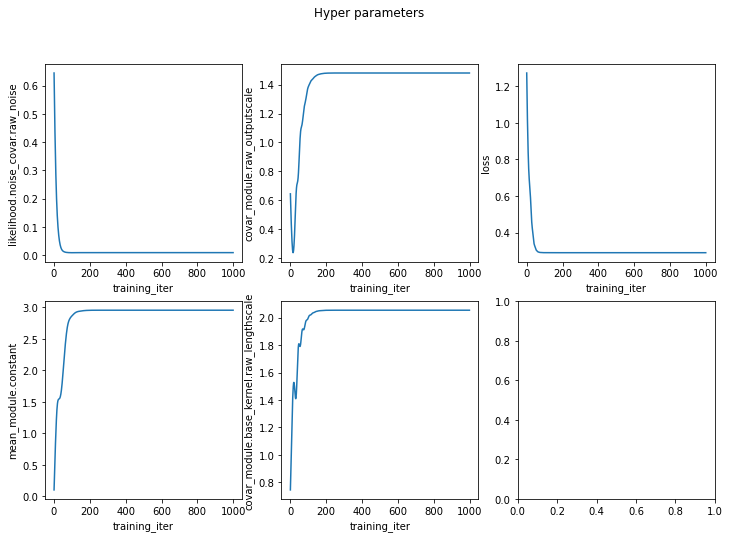

dict_keys(['likelihood.noise_covar.raw_noise', 'mean_module.constant', 'covar_module.raw_outputscale', 'covar_module.base_kernel.raw_lengthscale', 'loss'])


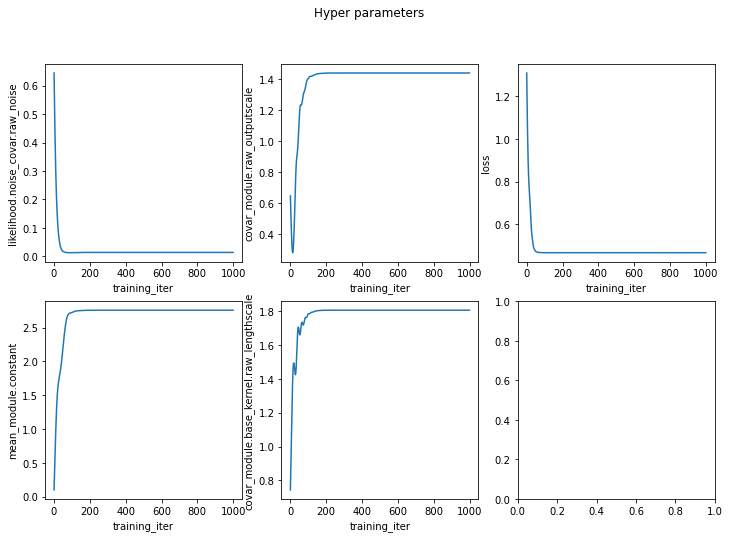

 10%|████▍                                       | 1/10 [00:15<02:22, 15.79s/it]

dict_keys(['likelihood.noise_covar.raw_noise', 'mean_module.constant', 'covar_module.raw_outputscale', 'covar_module.base_kernel.raw_lengthscale', 'loss'])


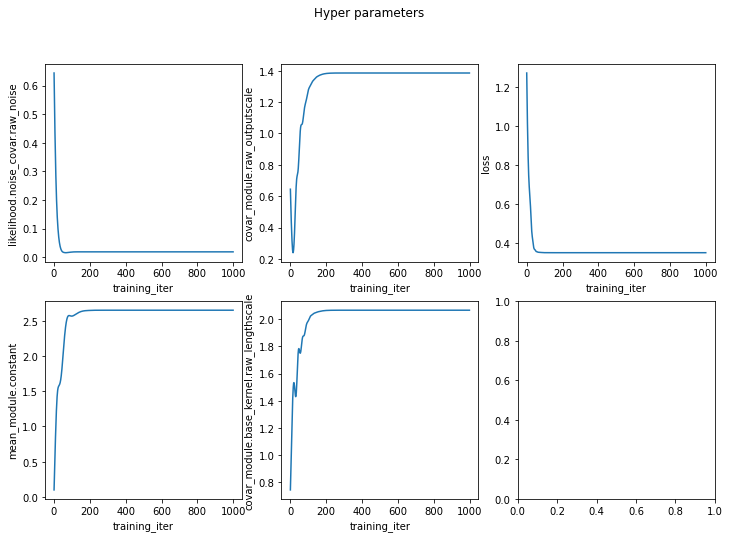

dict_keys(['likelihood.noise_covar.raw_noise', 'mean_module.constant', 'covar_module.raw_outputscale', 'covar_module.base_kernel.raw_lengthscale', 'loss'])


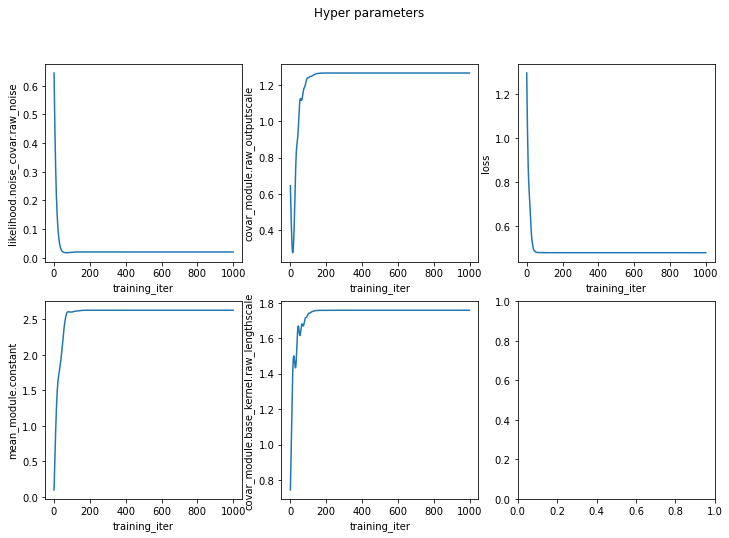

 20%|████████▊                                   | 2/10 [00:27<01:47, 13.46s/it]

dict_keys(['likelihood.noise_covar.raw_noise', 'mean_module.constant', 'covar_module.raw_outputscale', 'covar_module.base_kernel.raw_lengthscale', 'loss'])


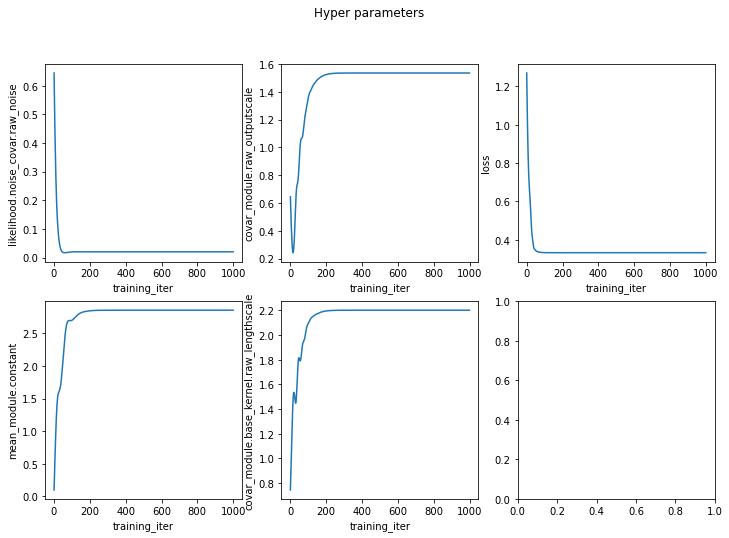

dict_keys(['likelihood.noise_covar.raw_noise', 'mean_module.constant', 'covar_module.raw_outputscale', 'covar_module.base_kernel.raw_lengthscale', 'loss'])


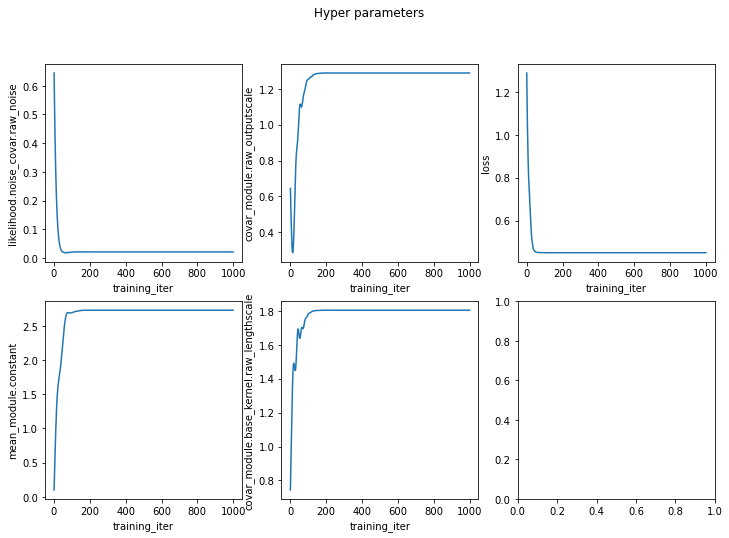

 30%|█████████████▏                              | 3/10 [00:38<01:26, 12.37s/it]

dict_keys(['likelihood.noise_covar.raw_noise', 'mean_module.constant', 'covar_module.raw_outputscale', 'covar_module.base_kernel.raw_lengthscale', 'loss'])


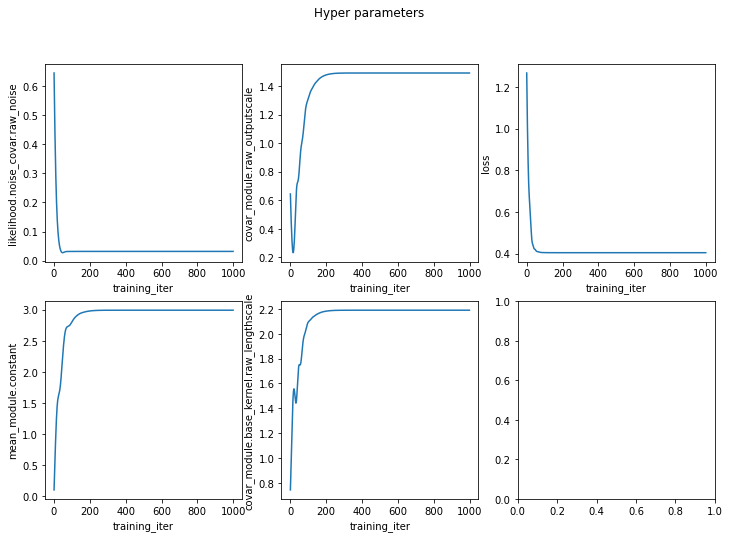

dict_keys(['likelihood.noise_covar.raw_noise', 'mean_module.constant', 'covar_module.raw_outputscale', 'covar_module.base_kernel.raw_lengthscale', 'loss'])


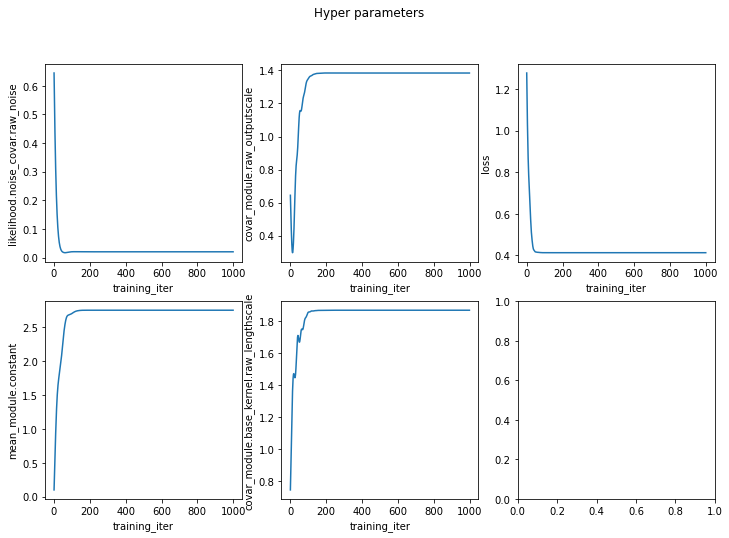

 40%|█████████████████▌                          | 4/10 [00:50<01:11, 11.96s/it]

dict_keys(['likelihood.noise_covar.raw_noise', 'mean_module.constant', 'covar_module.raw_outputscale', 'covar_module.base_kernel.raw_lengthscale', 'loss'])


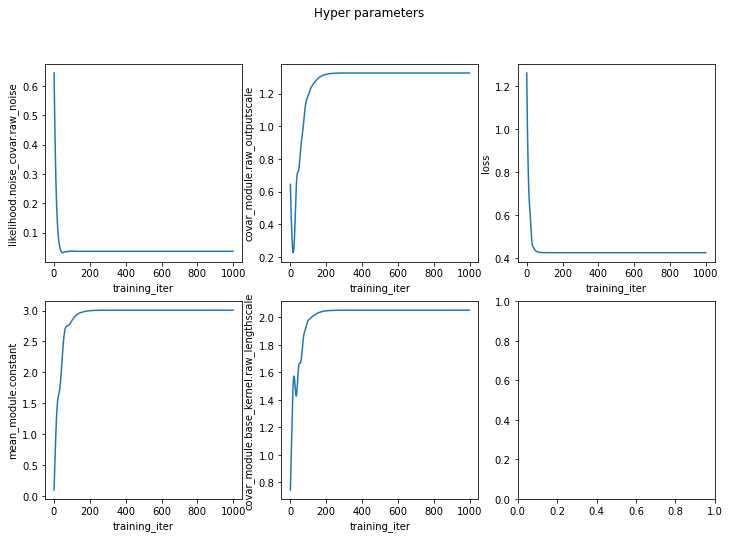

dict_keys(['likelihood.noise_covar.raw_noise', 'mean_module.constant', 'covar_module.raw_outputscale', 'covar_module.base_kernel.raw_lengthscale', 'loss'])


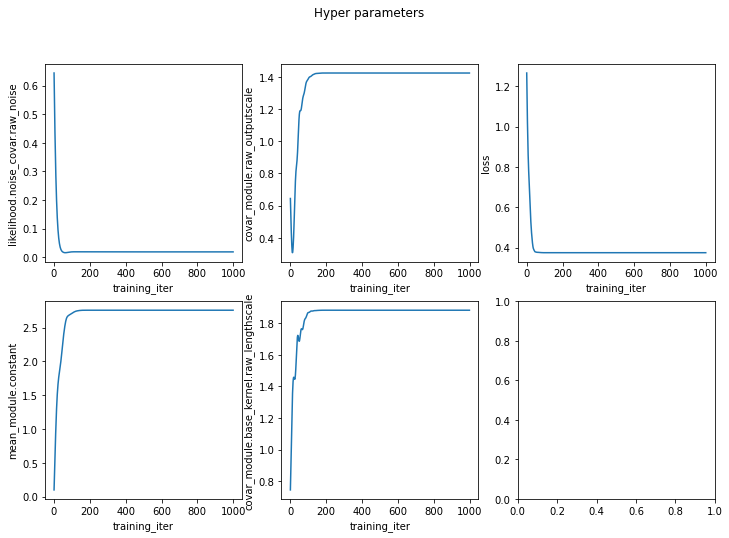

 50%|██████████████████████                      | 5/10 [01:02<00:59, 11.99s/it]

dict_keys(['likelihood.noise_covar.raw_noise', 'mean_module.constant', 'covar_module.raw_outputscale', 'covar_module.base_kernel.raw_lengthscale', 'loss'])


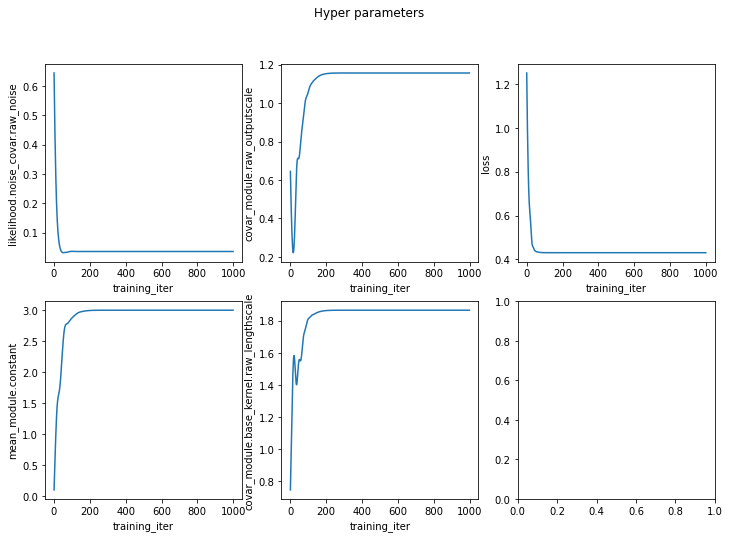

dict_keys(['likelihood.noise_covar.raw_noise', 'mean_module.constant', 'covar_module.raw_outputscale', 'covar_module.base_kernel.raw_lengthscale', 'loss'])


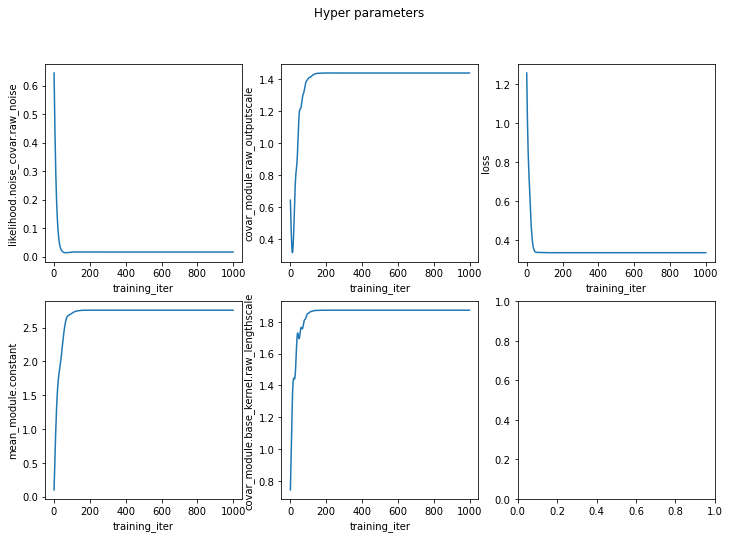

 60%|██████████████████████████▍                 | 6/10 [01:12<00:45, 11.48s/it]

dict_keys(['likelihood.noise_covar.raw_noise', 'mean_module.constant', 'covar_module.raw_outputscale', 'covar_module.base_kernel.raw_lengthscale', 'loss'])


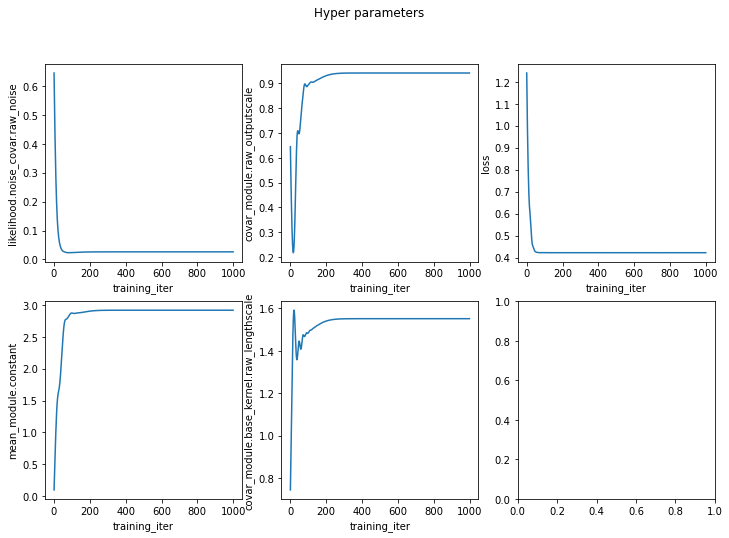

dict_keys(['likelihood.noise_covar.raw_noise', 'mean_module.constant', 'covar_module.raw_outputscale', 'covar_module.base_kernel.raw_lengthscale', 'loss'])


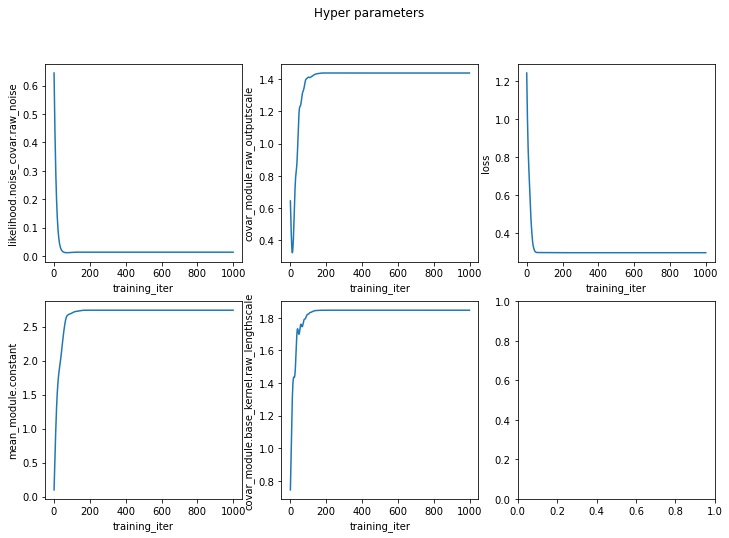

 70%|██████████████████████████████▊             | 7/10 [01:24<00:34, 11.59s/it]

dict_keys(['likelihood.noise_covar.raw_noise', 'mean_module.constant', 'covar_module.raw_outputscale', 'covar_module.base_kernel.raw_lengthscale', 'loss'])


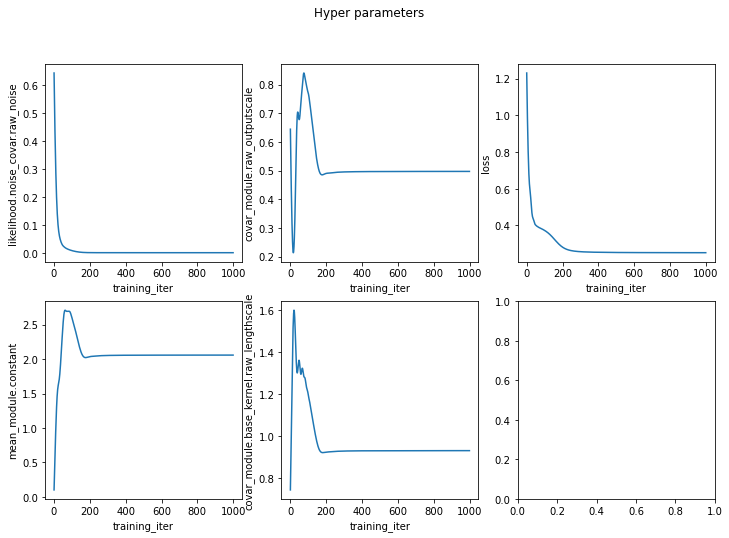

dict_keys(['likelihood.noise_covar.raw_noise', 'mean_module.constant', 'covar_module.raw_outputscale', 'covar_module.base_kernel.raw_lengthscale', 'loss'])


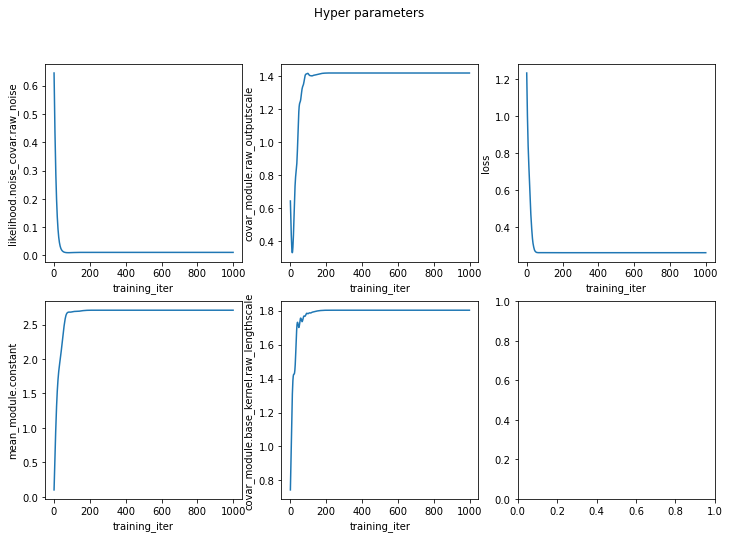

 80%|███████████████████████████████████▏        | 8/10 [01:36<00:23, 11.70s/it]

dict_keys(['likelihood.noise_covar.raw_noise', 'mean_module.constant', 'covar_module.raw_outputscale', 'covar_module.base_kernel.raw_lengthscale', 'loss'])


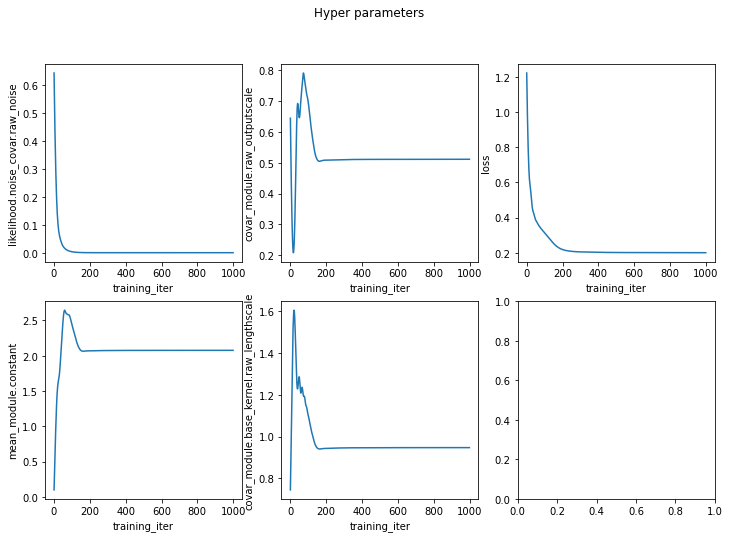

dict_keys(['likelihood.noise_covar.raw_noise', 'mean_module.constant', 'covar_module.raw_outputscale', 'covar_module.base_kernel.raw_lengthscale', 'loss'])


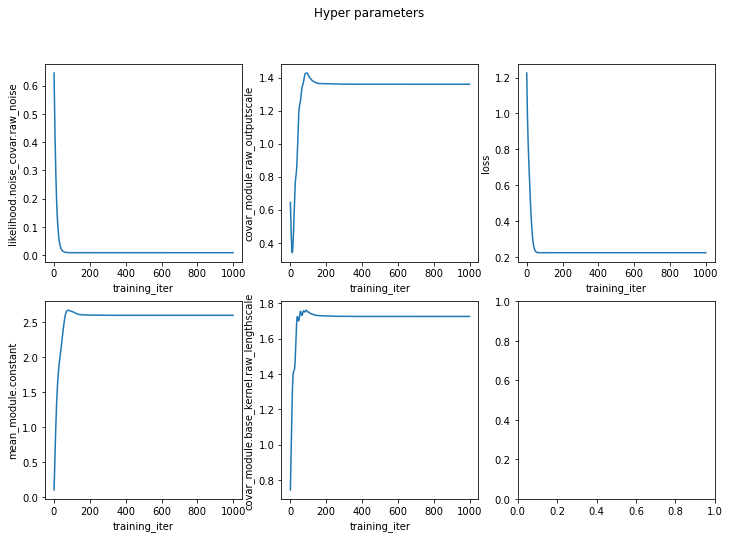

 90%|███████████████████████████████████████▌    | 9/10 [01:49<00:12, 12.05s/it]

dict_keys(['likelihood.noise_covar.raw_noise', 'mean_module.constant', 'covar_module.raw_outputscale', 'covar_module.base_kernel.raw_lengthscale', 'loss'])


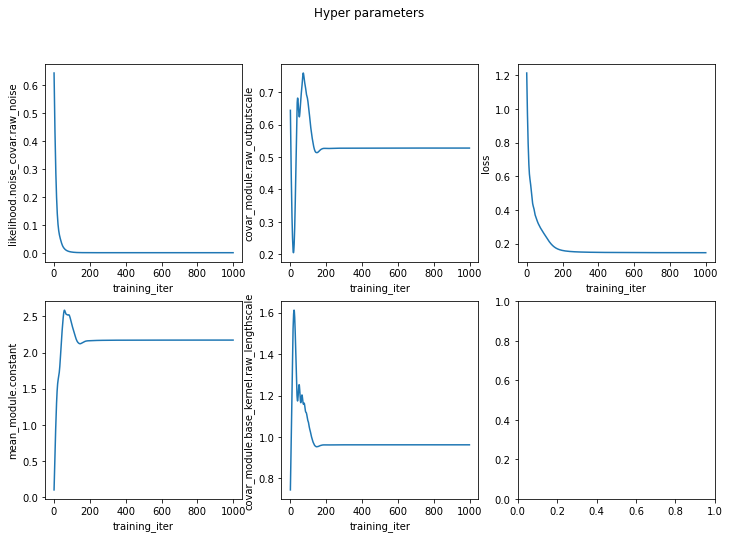

dict_keys(['likelihood.noise_covar.raw_noise', 'mean_module.constant', 'covar_module.raw_outputscale', 'covar_module.base_kernel.raw_lengthscale', 'loss'])


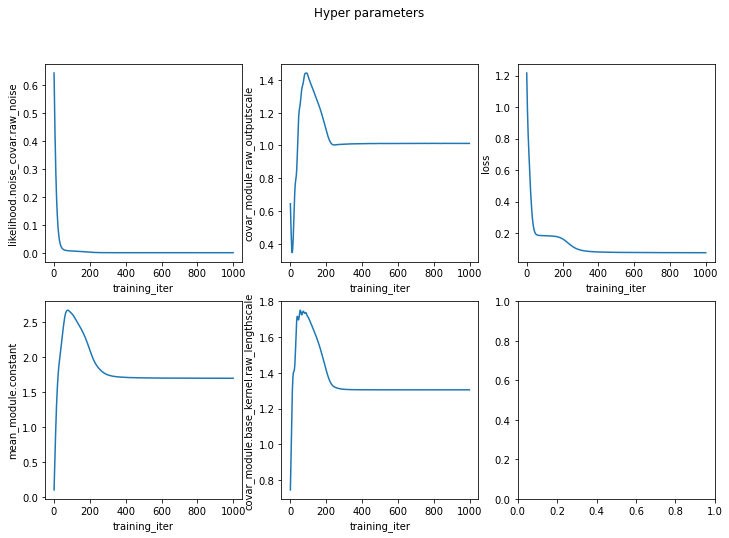

  0%|                                                    | 0/10 [00:00<?, ?it/s]

dict_keys(['likelihood.noise_covar.raw_noise', 'mean_module.constant', 'covar_module.raw_outputscale', 'covar_module.base_kernel.raw_lengthscale', 'loss'])


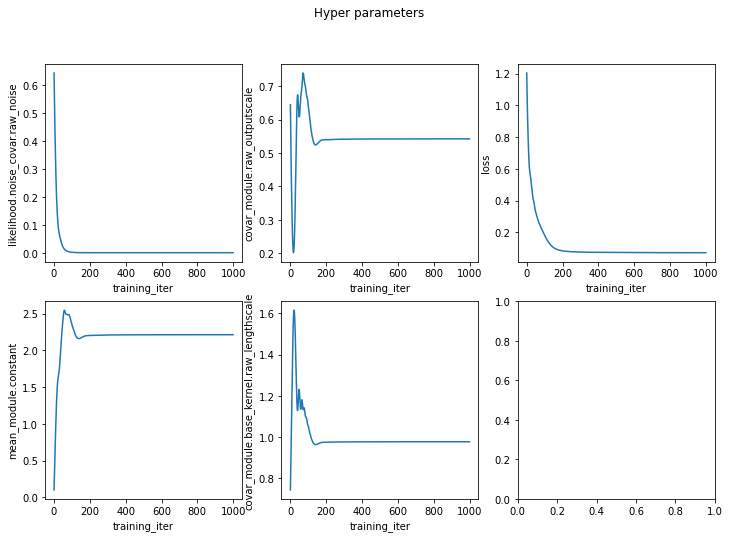

dict_keys(['likelihood.noise_covar.raw_noise', 'mean_module.constant', 'covar_module.raw_outputscale', 'covar_module.base_kernel.raw_lengthscale', 'loss'])


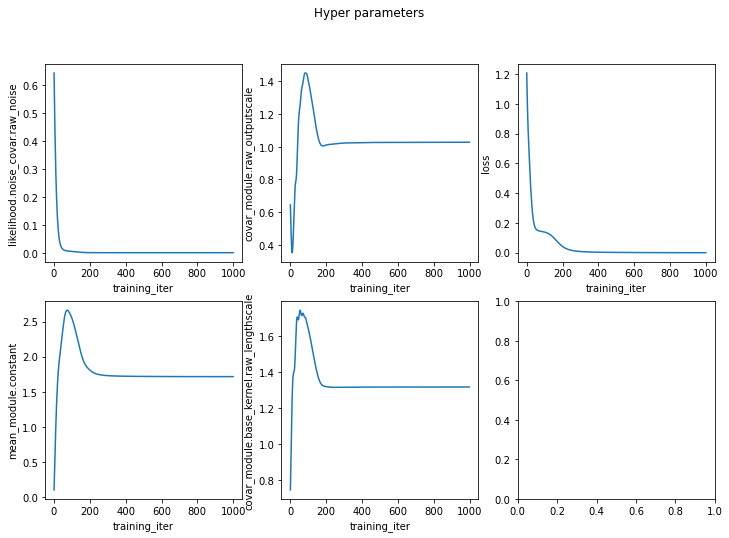

 10%|████▍                                       | 1/10 [00:11<01:47, 11.97s/it]

dict_keys(['likelihood.noise_covar.raw_noise', 'mean_module.constant', 'covar_module.raw_outputscale', 'covar_module.base_kernel.raw_lengthscale', 'loss'])


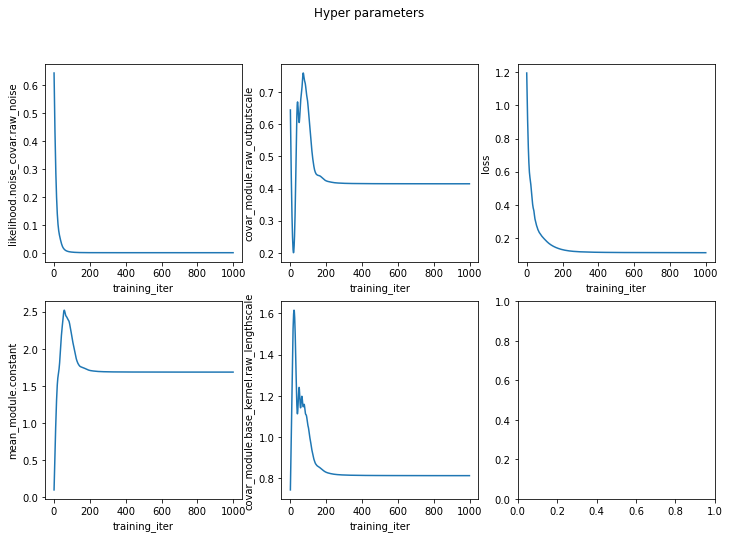

dict_keys(['likelihood.noise_covar.raw_noise', 'mean_module.constant', 'covar_module.raw_outputscale', 'covar_module.base_kernel.raw_lengthscale', 'loss'])


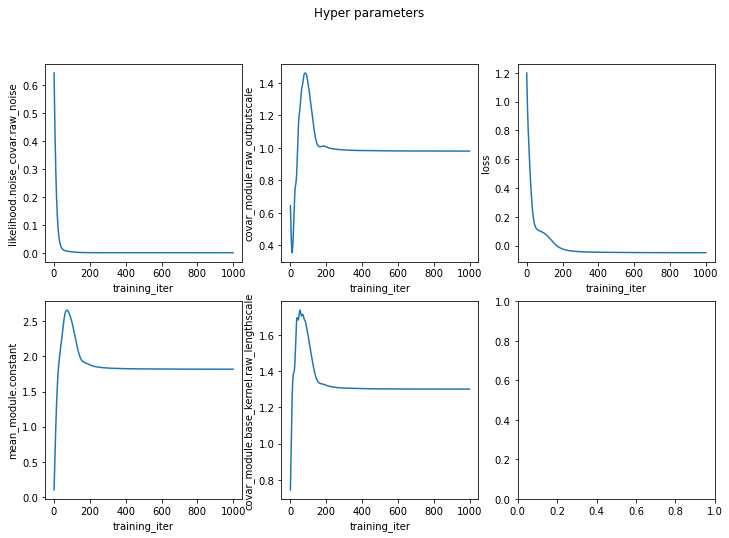

 20%|████████▊                                   | 2/10 [00:25<01:42, 12.82s/it]

dict_keys(['likelihood.noise_covar.raw_noise', 'mean_module.constant', 'covar_module.raw_outputscale', 'covar_module.base_kernel.raw_lengthscale', 'loss'])


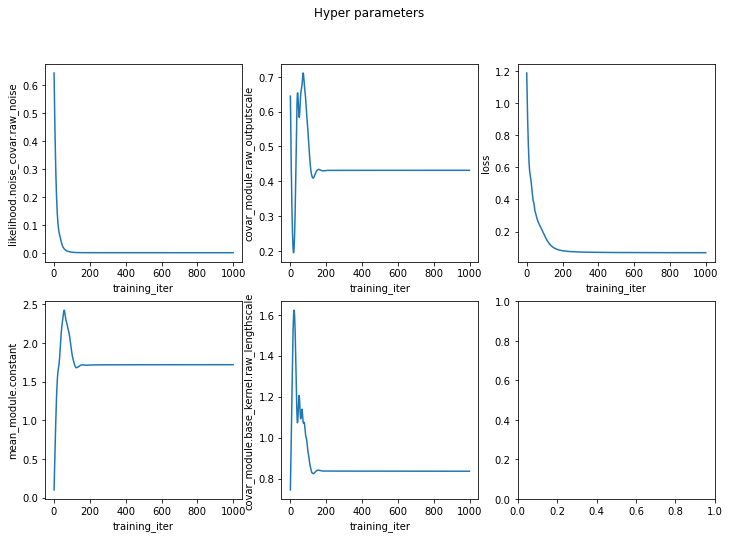

dict_keys(['likelihood.noise_covar.raw_noise', 'mean_module.constant', 'covar_module.raw_outputscale', 'covar_module.base_kernel.raw_lengthscale', 'loss'])


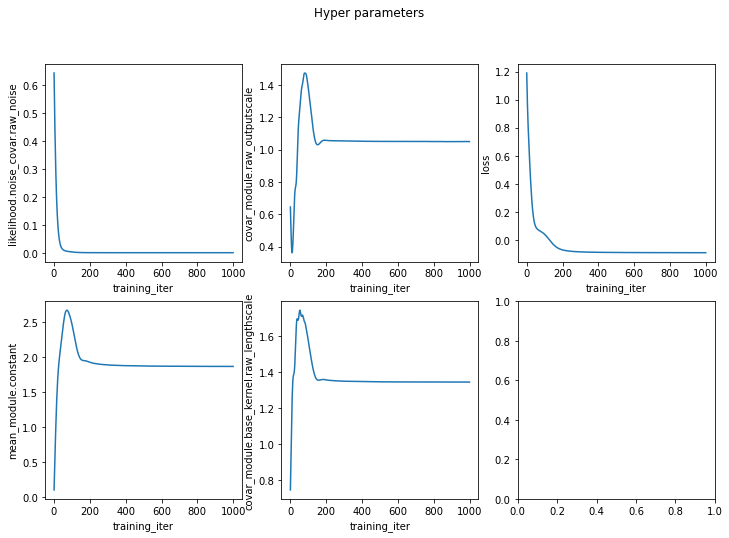

 30%|█████████████▏                              | 3/10 [00:40<01:35, 13.70s/it]

dict_keys(['likelihood.noise_covar.raw_noise', 'mean_module.constant', 'covar_module.raw_outputscale', 'covar_module.base_kernel.raw_lengthscale', 'loss'])


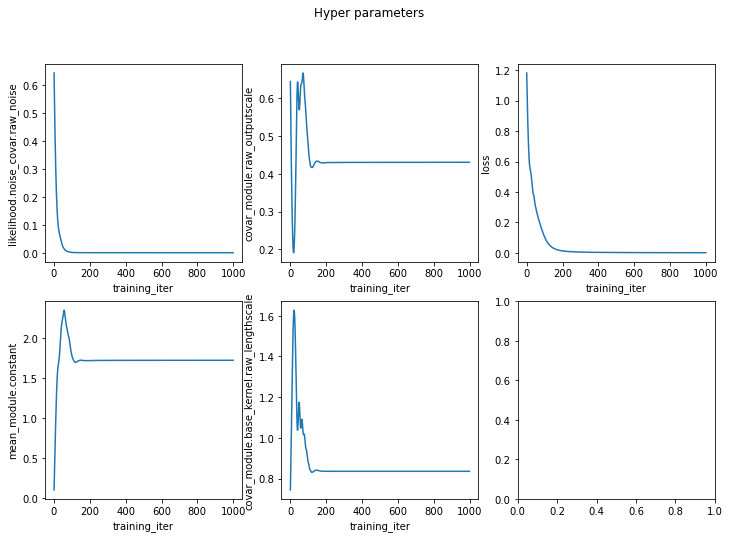

dict_keys(['likelihood.noise_covar.raw_noise', 'mean_module.constant', 'covar_module.raw_outputscale', 'covar_module.base_kernel.raw_lengthscale', 'loss'])


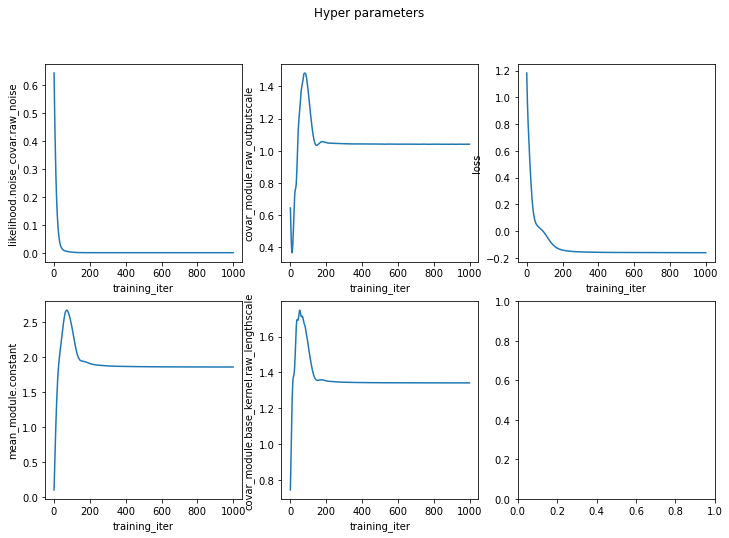

 40%|█████████████████▌                          | 4/10 [00:52<01:19, 13.20s/it]

dict_keys(['likelihood.noise_covar.raw_noise', 'mean_module.constant', 'covar_module.raw_outputscale', 'covar_module.base_kernel.raw_lengthscale', 'loss'])


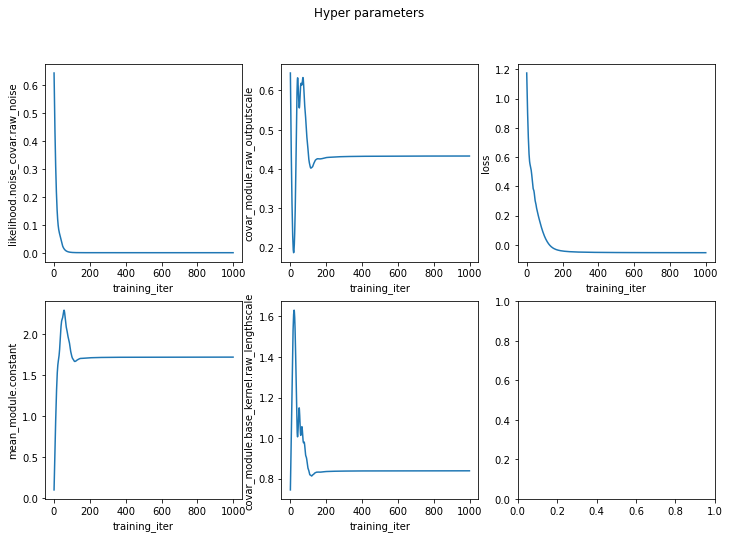

dict_keys(['likelihood.noise_covar.raw_noise', 'mean_module.constant', 'covar_module.raw_outputscale', 'covar_module.base_kernel.raw_lengthscale', 'loss'])


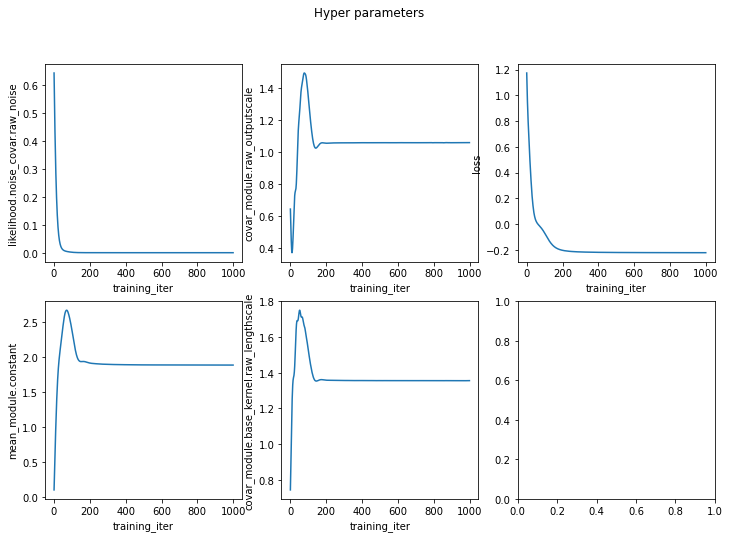

 50%|██████████████████████                      | 5/10 [01:04<01:04, 12.84s/it]

dict_keys(['likelihood.noise_covar.raw_noise', 'mean_module.constant', 'covar_module.raw_outputscale', 'covar_module.base_kernel.raw_lengthscale', 'loss'])


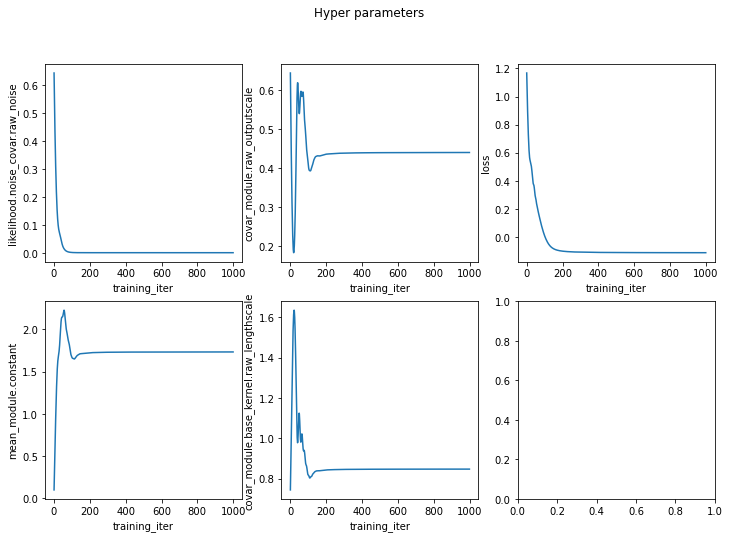

dict_keys(['likelihood.noise_covar.raw_noise', 'mean_module.constant', 'covar_module.raw_outputscale', 'covar_module.base_kernel.raw_lengthscale', 'loss'])


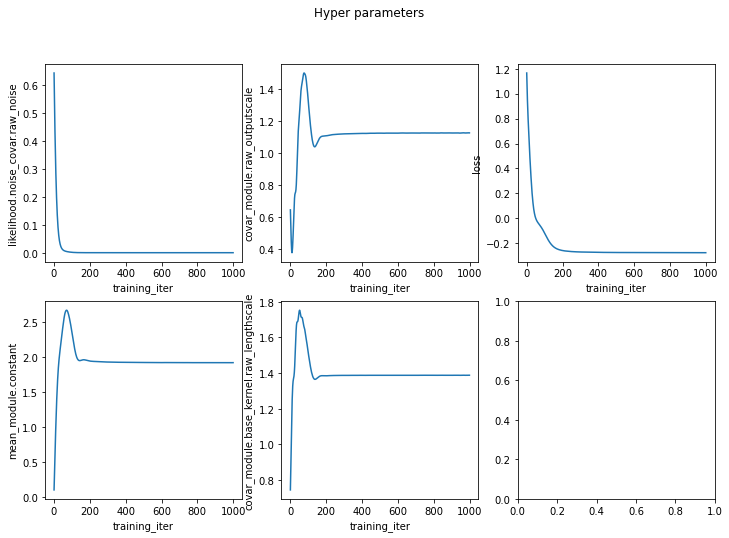

 60%|██████████████████████████▍                 | 6/10 [01:17<00:51, 12.82s/it]

dict_keys(['likelihood.noise_covar.raw_noise', 'mean_module.constant', 'covar_module.raw_outputscale', 'covar_module.base_kernel.raw_lengthscale', 'loss'])


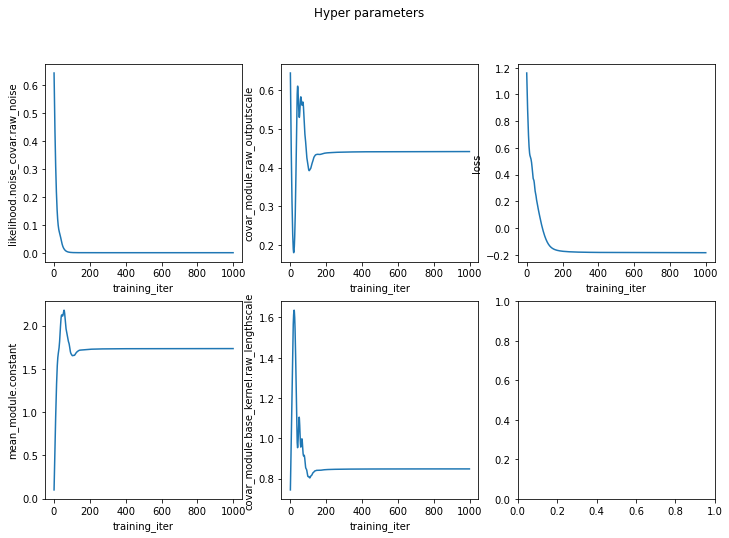

dict_keys(['likelihood.noise_covar.raw_noise', 'mean_module.constant', 'covar_module.raw_outputscale', 'covar_module.base_kernel.raw_lengthscale', 'loss'])


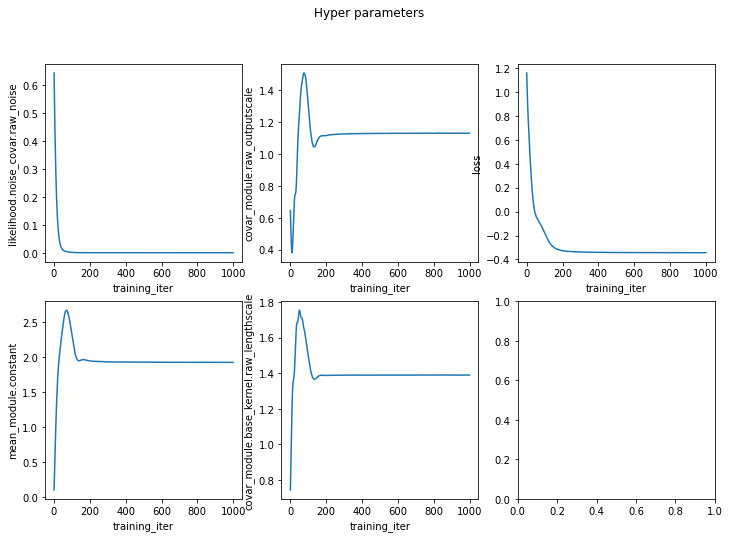

 70%|██████████████████████████████▊             | 7/10 [01:28<00:36, 12.10s/it]

dict_keys(['likelihood.noise_covar.raw_noise', 'mean_module.constant', 'covar_module.raw_outputscale', 'covar_module.base_kernel.raw_lengthscale', 'loss'])


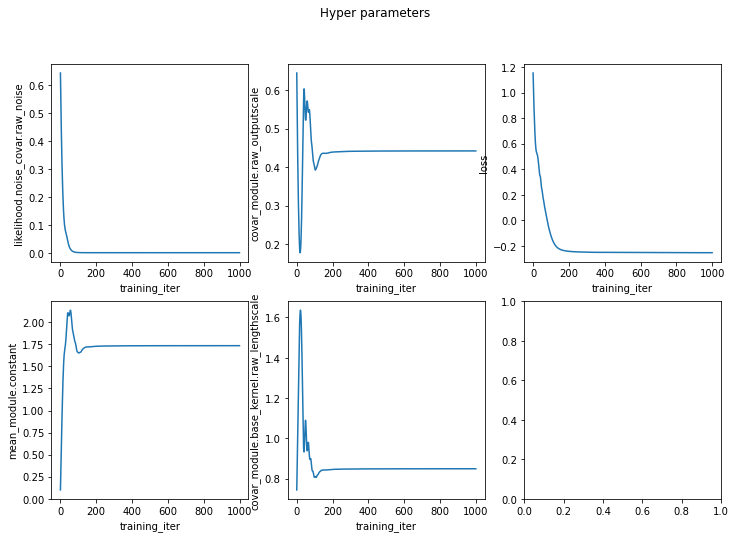

dict_keys(['likelihood.noise_covar.raw_noise', 'mean_module.constant', 'covar_module.raw_outputscale', 'covar_module.base_kernel.raw_lengthscale', 'loss'])


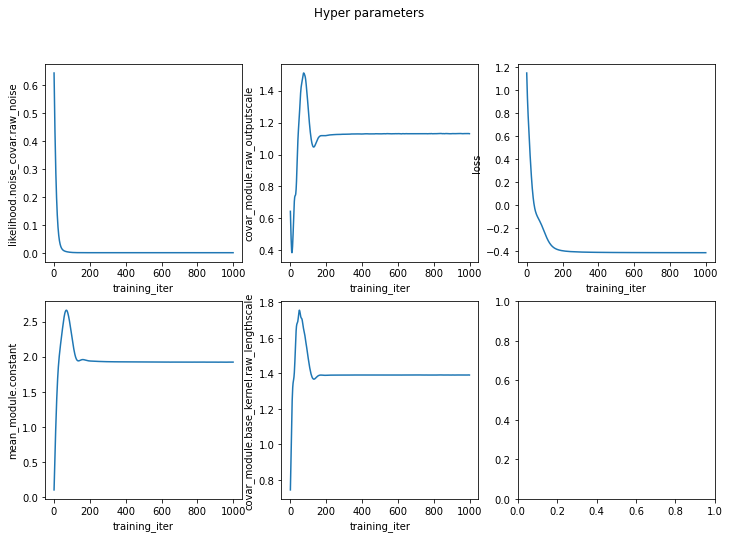

 80%|███████████████████████████████████▏        | 8/10 [01:38<00:23, 11.62s/it]

dict_keys(['likelihood.noise_covar.raw_noise', 'mean_module.constant', 'covar_module.raw_outputscale', 'covar_module.base_kernel.raw_lengthscale', 'loss'])


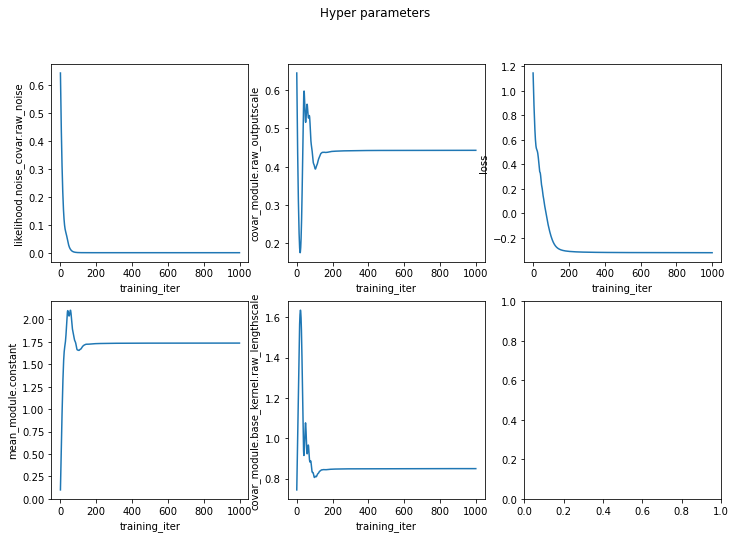

dict_keys(['likelihood.noise_covar.raw_noise', 'mean_module.constant', 'covar_module.raw_outputscale', 'covar_module.base_kernel.raw_lengthscale', 'loss'])


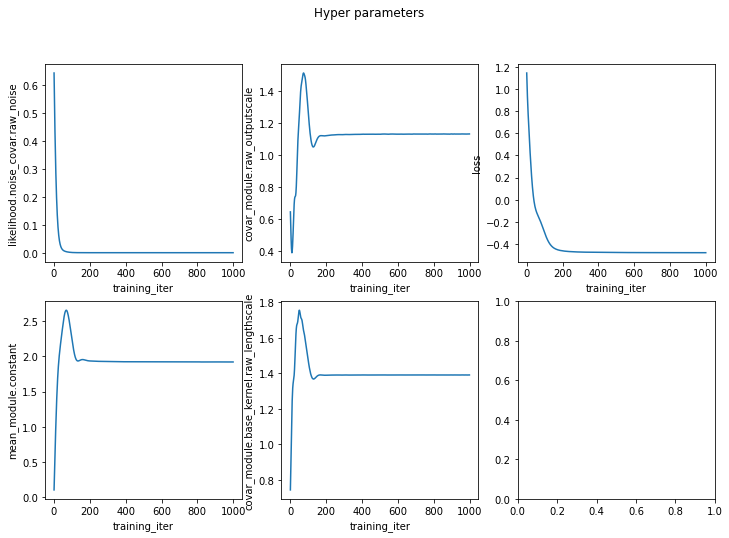

 90%|███████████████████████████████████████▌    | 9/10 [01:50<00:11, 11.76s/it]

dict_keys(['likelihood.noise_covar.raw_noise', 'mean_module.constant', 'covar_module.raw_outputscale', 'covar_module.base_kernel.raw_lengthscale', 'loss'])


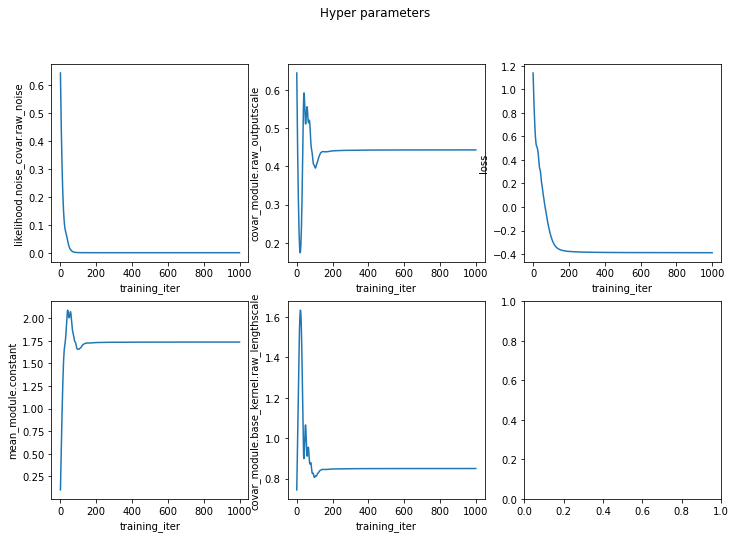

dict_keys(['likelihood.noise_covar.raw_noise', 'mean_module.constant', 'covar_module.raw_outputscale', 'covar_module.base_kernel.raw_lengthscale', 'loss'])


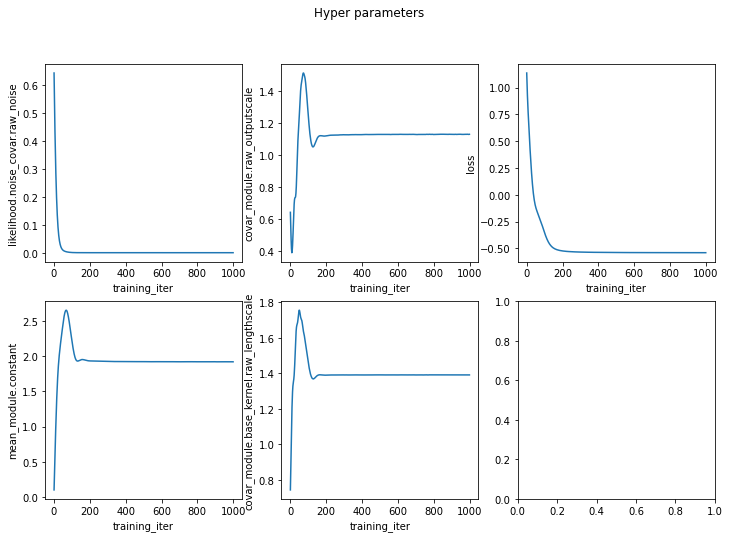

  0%|                                                    | 0/10 [00:00<?, ?it/s]

dict_keys(['likelihood.noise_covar.raw_noise', 'mean_module.constant', 'covar_module.raw_outputscale', 'covar_module.base_kernel.raw_lengthscale', 'loss'])


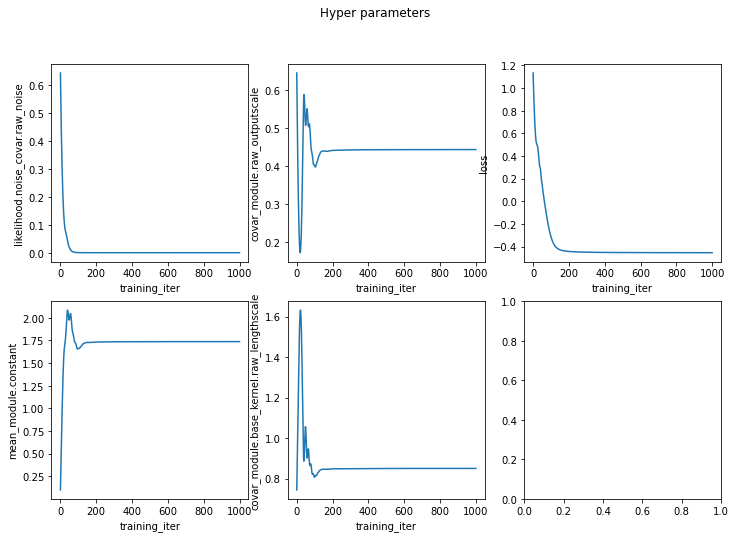

dict_keys(['likelihood.noise_covar.raw_noise', 'mean_module.constant', 'covar_module.raw_outputscale', 'covar_module.base_kernel.raw_lengthscale', 'loss'])


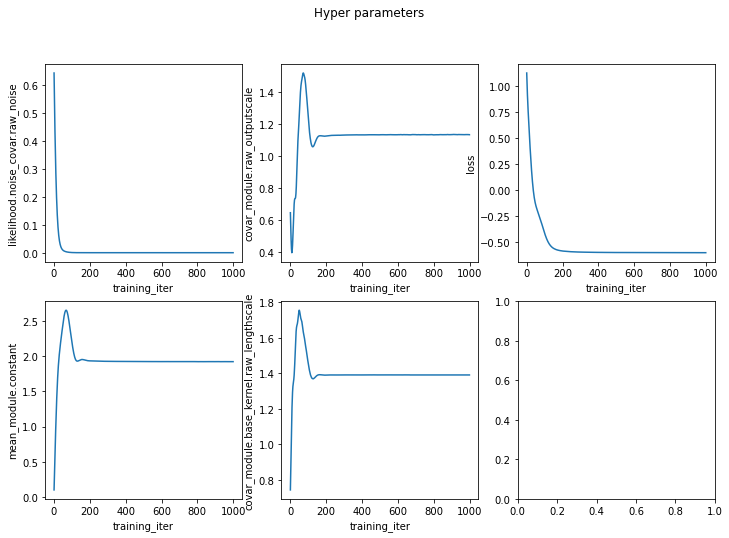

 10%|████▍                                       | 1/10 [00:16<02:32, 16.97s/it]

dict_keys(['likelihood.noise_covar.raw_noise', 'mean_module.constant', 'covar_module.raw_outputscale', 'covar_module.base_kernel.raw_lengthscale', 'loss'])


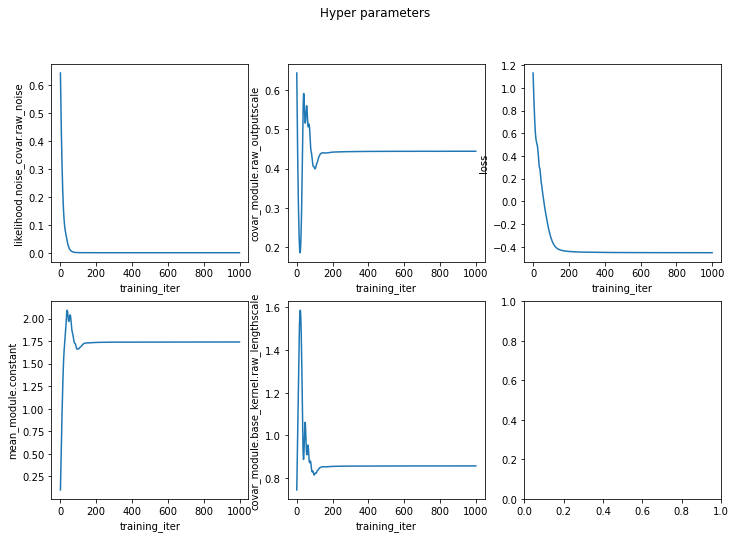

dict_keys(['likelihood.noise_covar.raw_noise', 'mean_module.constant', 'covar_module.raw_outputscale', 'covar_module.base_kernel.raw_lengthscale', 'loss'])


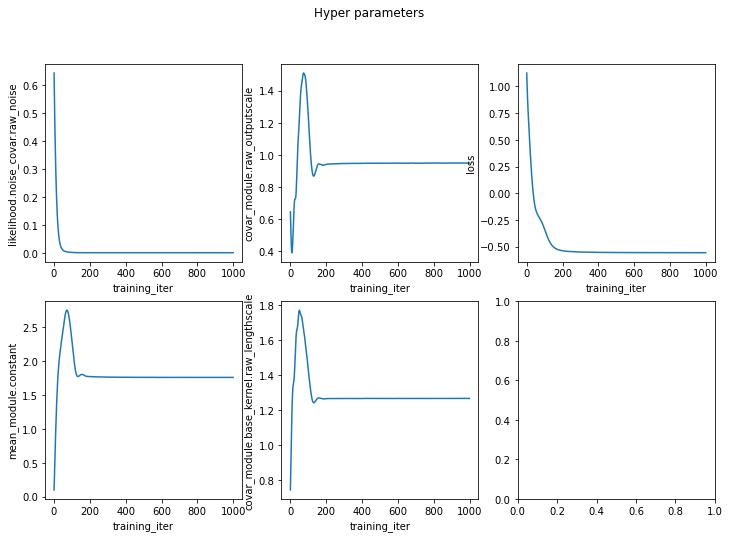

 20%|████████▊                                   | 2/10 [00:29<01:55, 14.39s/it]

dict_keys(['likelihood.noise_covar.raw_noise', 'mean_module.constant', 'covar_module.raw_outputscale', 'covar_module.base_kernel.raw_lengthscale', 'loss'])


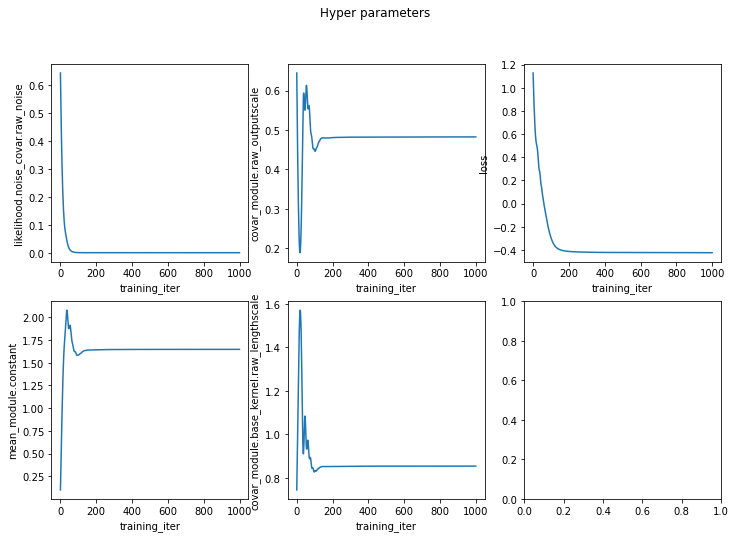

dict_keys(['likelihood.noise_covar.raw_noise', 'mean_module.constant', 'covar_module.raw_outputscale', 'covar_module.base_kernel.raw_lengthscale', 'loss'])


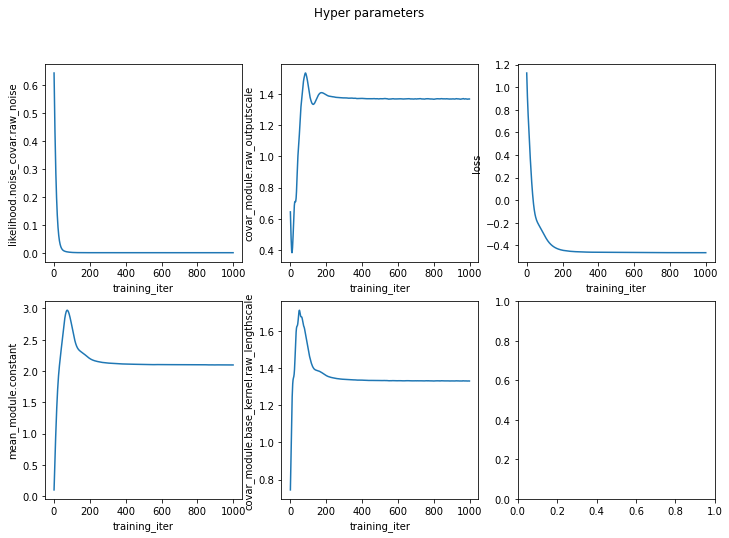

 30%|█████████████▏                              | 3/10 [00:47<01:50, 15.82s/it]

dict_keys(['likelihood.noise_covar.raw_noise', 'mean_module.constant', 'covar_module.raw_outputscale', 'covar_module.base_kernel.raw_lengthscale', 'loss'])


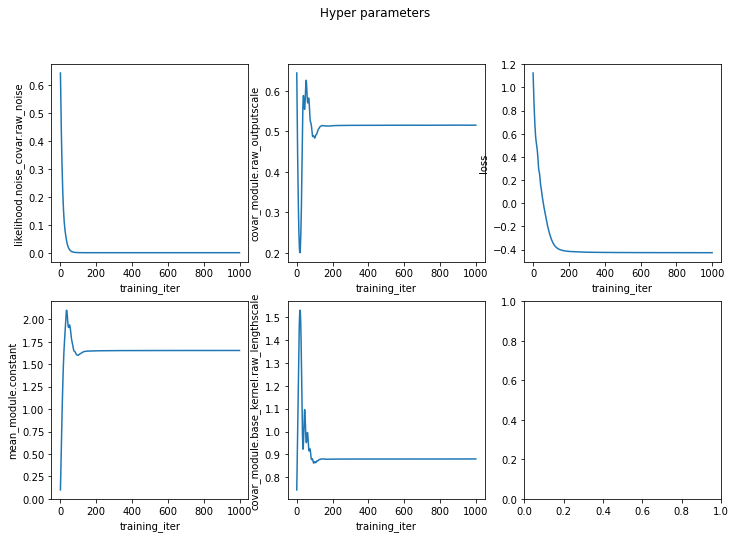

dict_keys(['likelihood.noise_covar.raw_noise', 'mean_module.constant', 'covar_module.raw_outputscale', 'covar_module.base_kernel.raw_lengthscale', 'loss'])


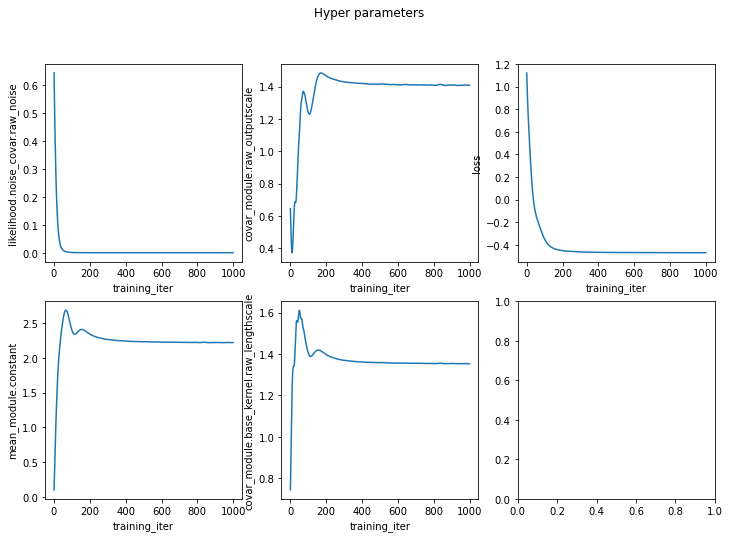

 40%|█████████████████▌                          | 4/10 [01:05<01:40, 16.80s/it]

dict_keys(['likelihood.noise_covar.raw_noise', 'mean_module.constant', 'covar_module.raw_outputscale', 'covar_module.base_kernel.raw_lengthscale', 'loss'])


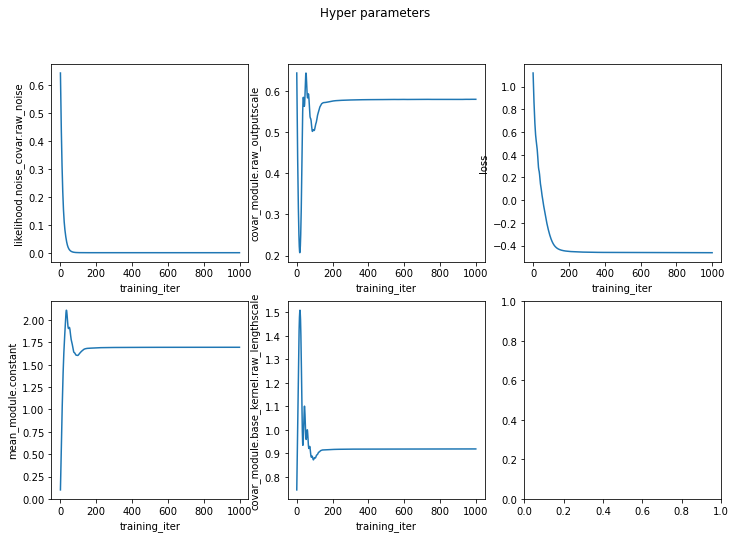

dict_keys(['likelihood.noise_covar.raw_noise', 'mean_module.constant', 'covar_module.raw_outputscale', 'covar_module.base_kernel.raw_lengthscale', 'loss'])


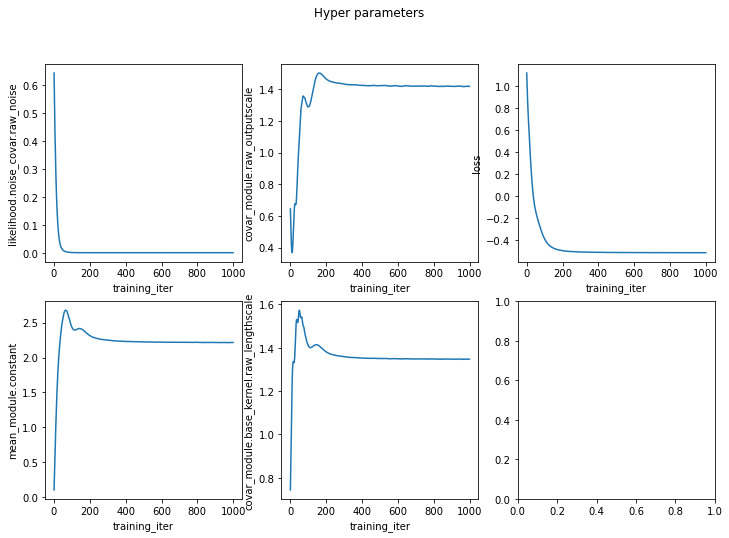

 50%|██████████████████████                      | 5/10 [01:22<01:24, 16.90s/it]

dict_keys(['likelihood.noise_covar.raw_noise', 'mean_module.constant', 'covar_module.raw_outputscale', 'covar_module.base_kernel.raw_lengthscale', 'loss'])


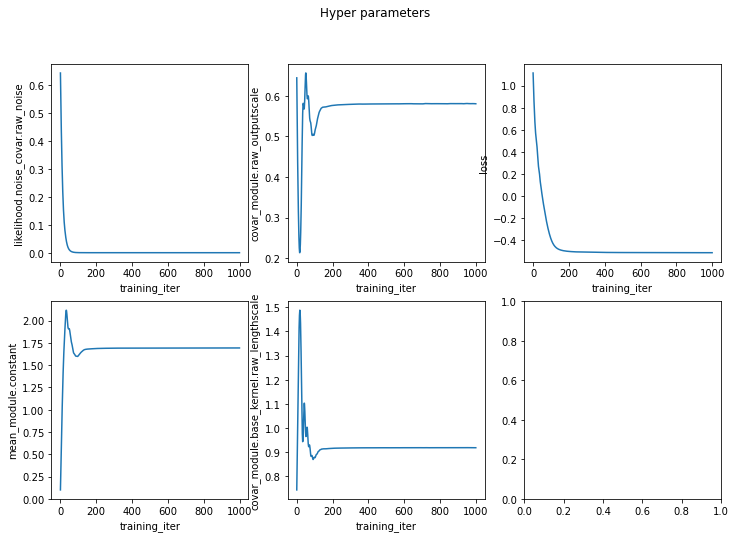

dict_keys(['likelihood.noise_covar.raw_noise', 'mean_module.constant', 'covar_module.raw_outputscale', 'covar_module.base_kernel.raw_lengthscale', 'loss'])


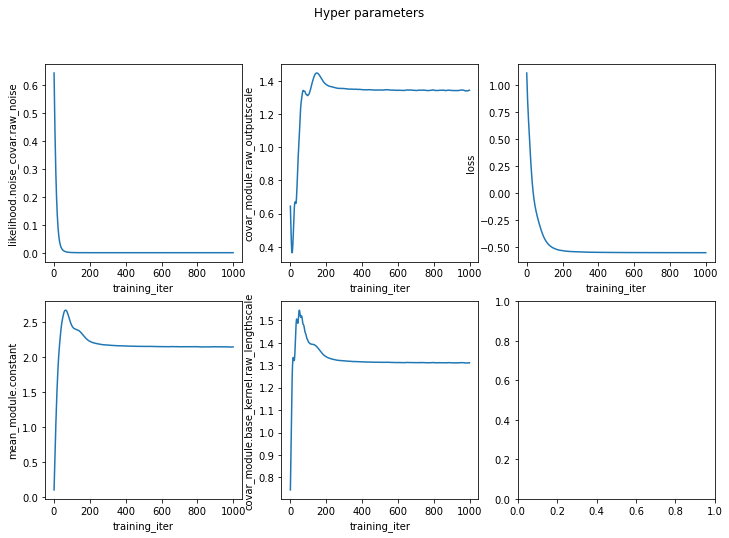

 60%|██████████████████████████▍                 | 6/10 [01:39<01:07, 16.93s/it]

dict_keys(['likelihood.noise_covar.raw_noise', 'mean_module.constant', 'covar_module.raw_outputscale', 'covar_module.base_kernel.raw_lengthscale', 'loss'])


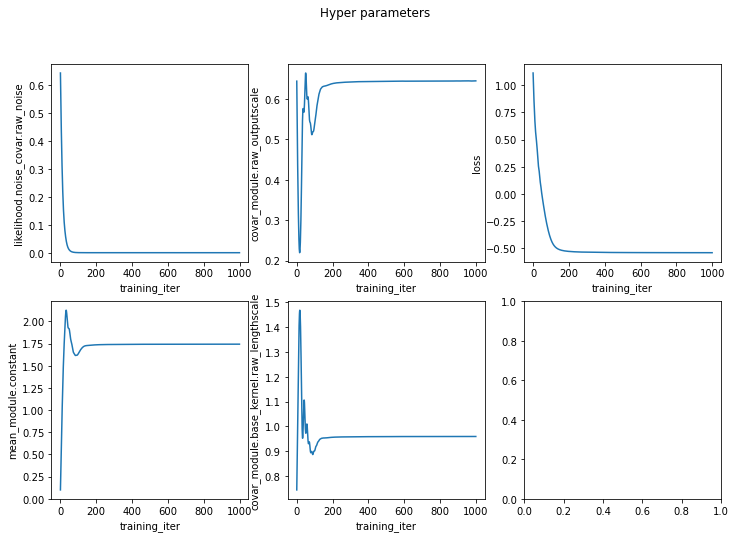

dict_keys(['likelihood.noise_covar.raw_noise', 'mean_module.constant', 'covar_module.raw_outputscale', 'covar_module.base_kernel.raw_lengthscale', 'loss'])


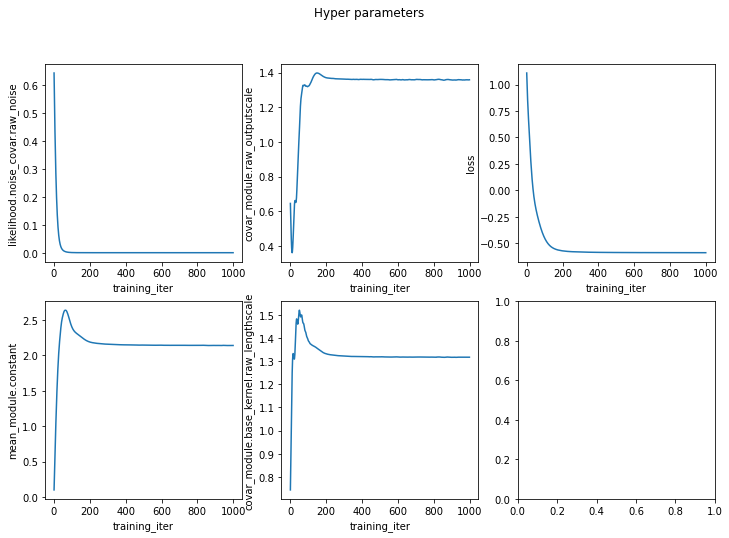

 70%|██████████████████████████████▊             | 7/10 [01:56<00:50, 16.90s/it]

dict_keys(['likelihood.noise_covar.raw_noise', 'mean_module.constant', 'covar_module.raw_outputscale', 'covar_module.base_kernel.raw_lengthscale', 'loss'])


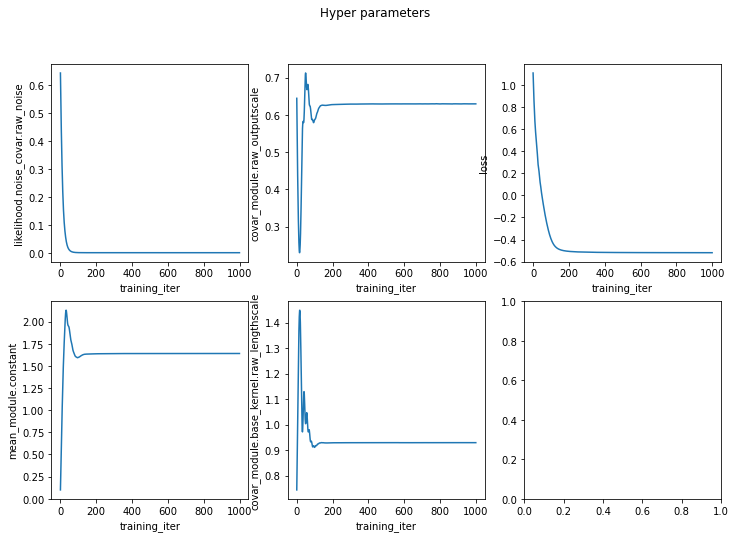

dict_keys(['likelihood.noise_covar.raw_noise', 'mean_module.constant', 'covar_module.raw_outputscale', 'covar_module.base_kernel.raw_lengthscale', 'loss'])


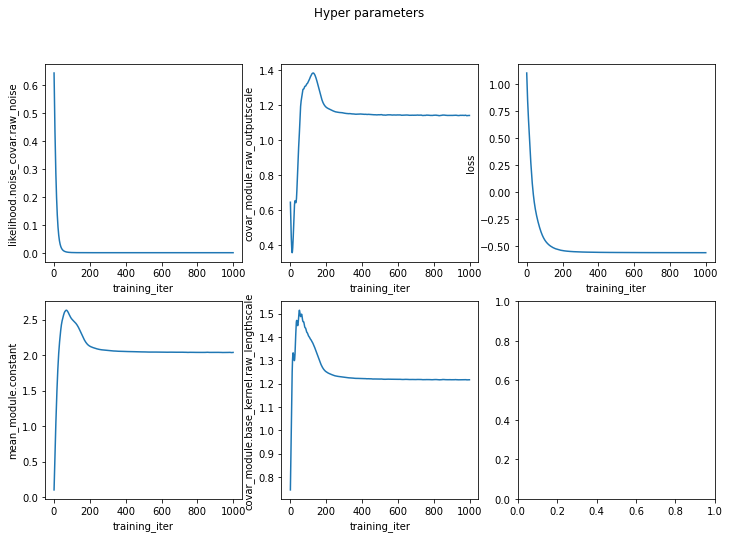

 80%|███████████████████████████████████▏        | 8/10 [02:13<00:33, 16.86s/it]

dict_keys(['likelihood.noise_covar.raw_noise', 'mean_module.constant', 'covar_module.raw_outputscale', 'covar_module.base_kernel.raw_lengthscale', 'loss'])


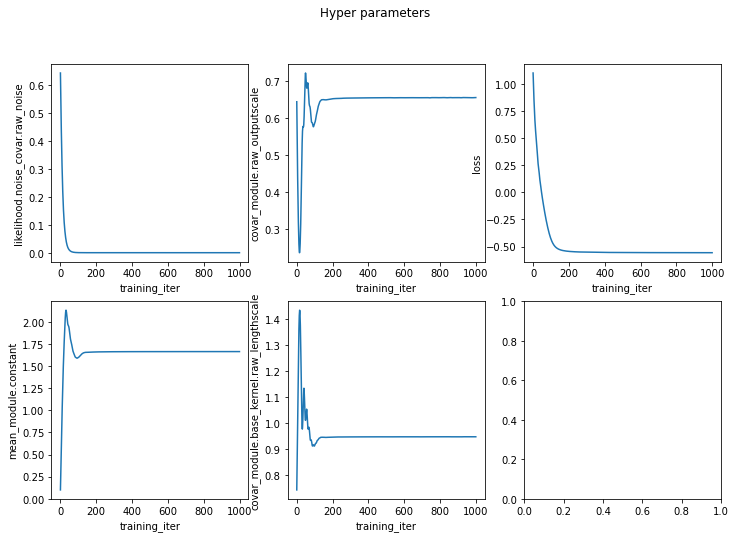

dict_keys(['likelihood.noise_covar.raw_noise', 'mean_module.constant', 'covar_module.raw_outputscale', 'covar_module.base_kernel.raw_lengthscale', 'loss'])


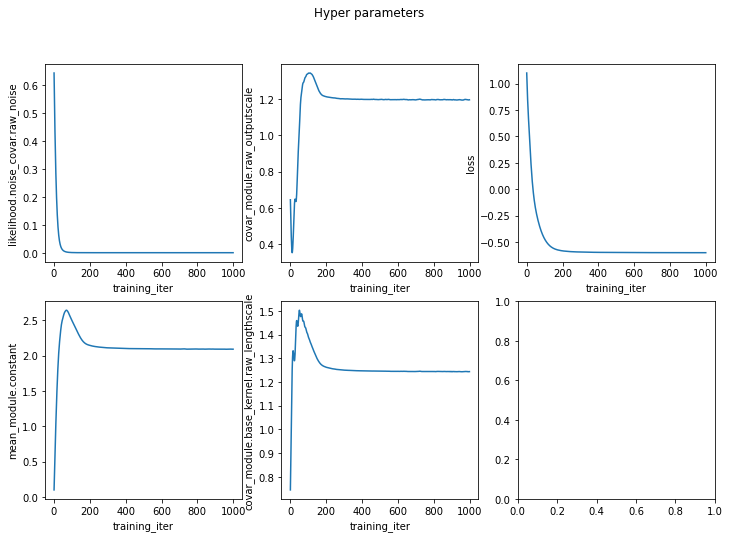

 90%|███████████████████████████████████████▌    | 9/10 [02:30<00:16, 16.93s/it]

dict_keys(['likelihood.noise_covar.raw_noise', 'mean_module.constant', 'covar_module.raw_outputscale', 'covar_module.base_kernel.raw_lengthscale', 'loss'])


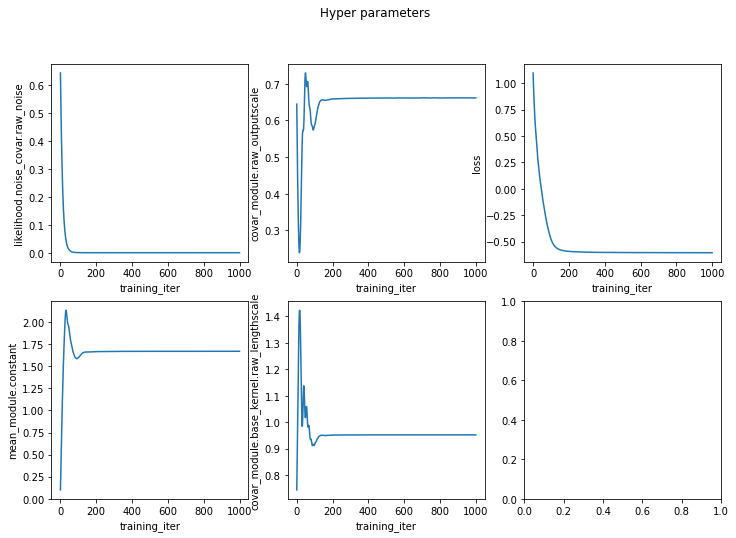

dict_keys(['likelihood.noise_covar.raw_noise', 'mean_module.constant', 'covar_module.raw_outputscale', 'covar_module.base_kernel.raw_lengthscale', 'loss'])


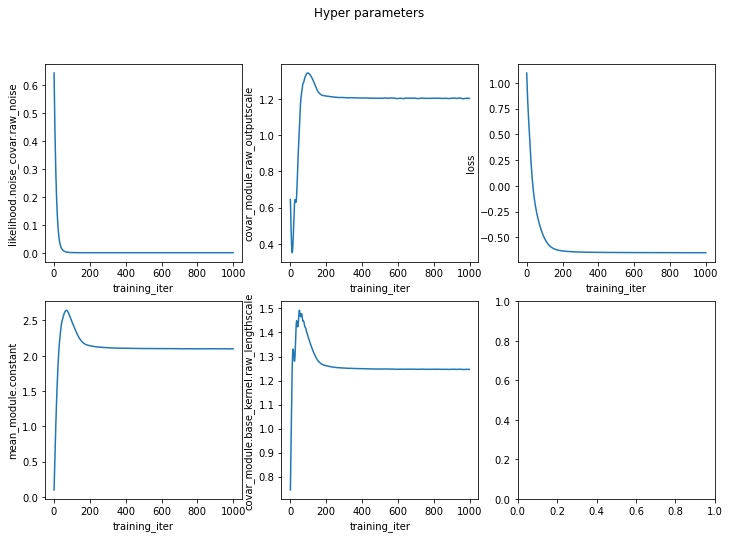

  0%|                                                    | 0/10 [00:00<?, ?it/s]

dict_keys(['likelihood.noise_covar.raw_noise', 'mean_module.constant', 'covar_module.raw_outputscale', 'covar_module.base_kernel.raw_lengthscale', 'loss'])


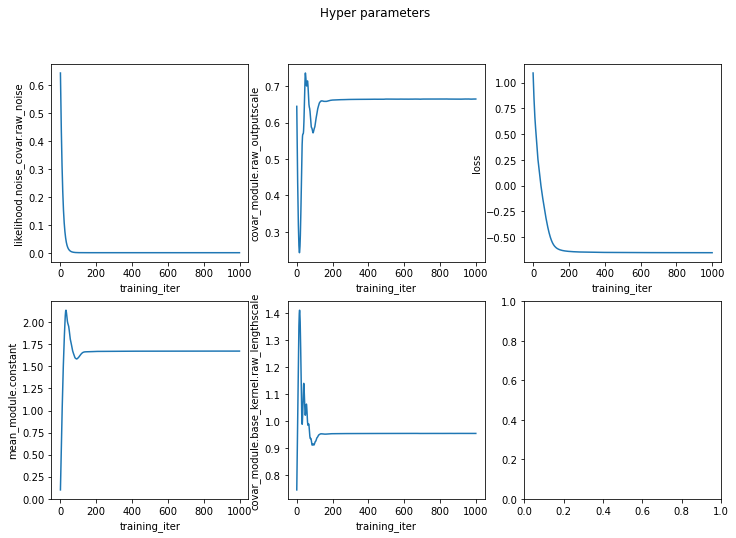

dict_keys(['likelihood.noise_covar.raw_noise', 'mean_module.constant', 'covar_module.raw_outputscale', 'covar_module.base_kernel.raw_lengthscale', 'loss'])


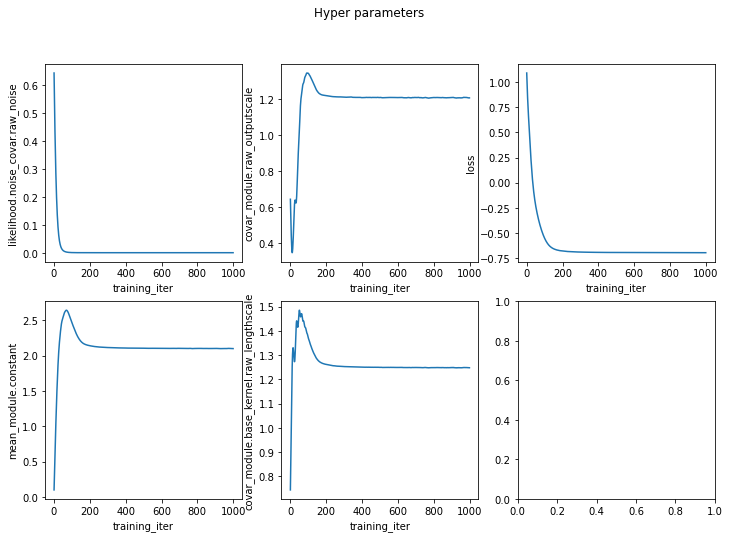

 10%|████▍                                       | 1/10 [00:17<02:33, 17.06s/it]

dict_keys(['likelihood.noise_covar.raw_noise', 'mean_module.constant', 'covar_module.raw_outputscale', 'covar_module.base_kernel.raw_lengthscale', 'loss'])


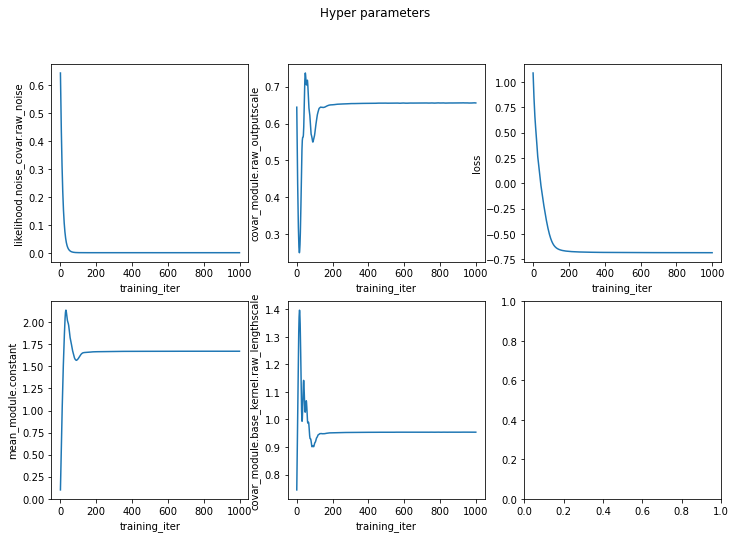

dict_keys(['likelihood.noise_covar.raw_noise', 'mean_module.constant', 'covar_module.raw_outputscale', 'covar_module.base_kernel.raw_lengthscale', 'loss'])


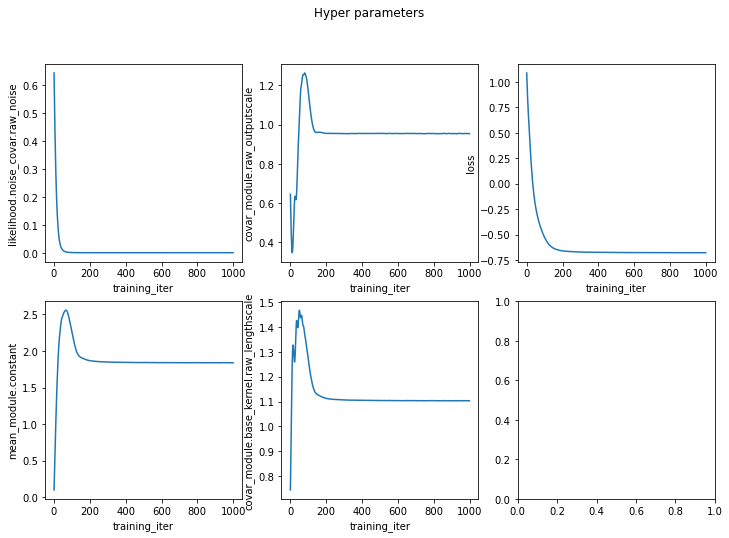

 20%|████████▊                                   | 2/10 [00:34<02:16, 17.01s/it]

dict_keys(['likelihood.noise_covar.raw_noise', 'mean_module.constant', 'covar_module.raw_outputscale', 'covar_module.base_kernel.raw_lengthscale', 'loss'])


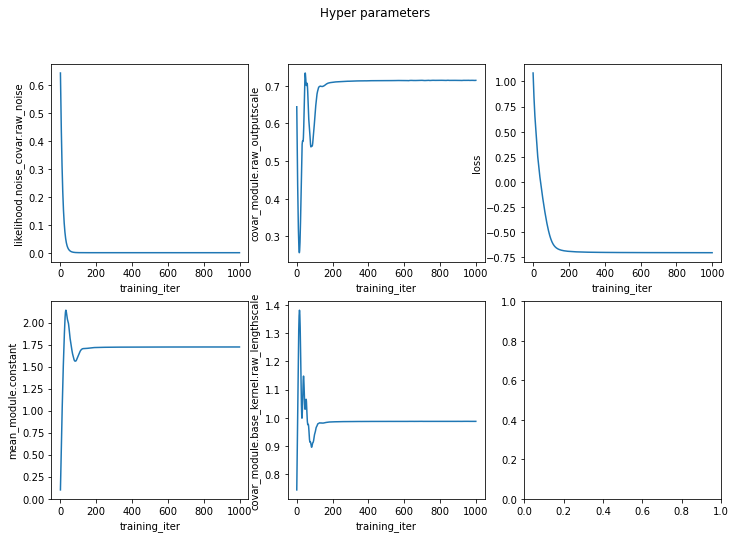

dict_keys(['likelihood.noise_covar.raw_noise', 'mean_module.constant', 'covar_module.raw_outputscale', 'covar_module.base_kernel.raw_lengthscale', 'loss'])


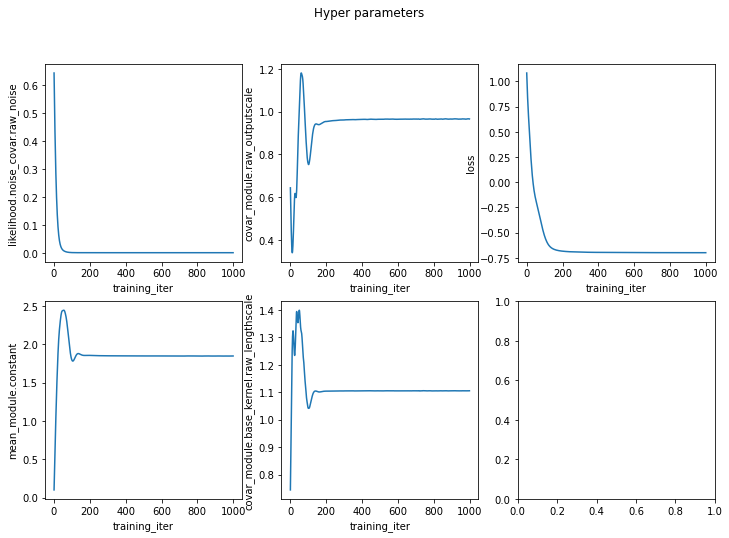

 30%|█████████████▏                              | 3/10 [00:50<01:58, 16.98s/it]

dict_keys(['likelihood.noise_covar.raw_noise', 'mean_module.constant', 'covar_module.raw_outputscale', 'covar_module.base_kernel.raw_lengthscale', 'loss'])


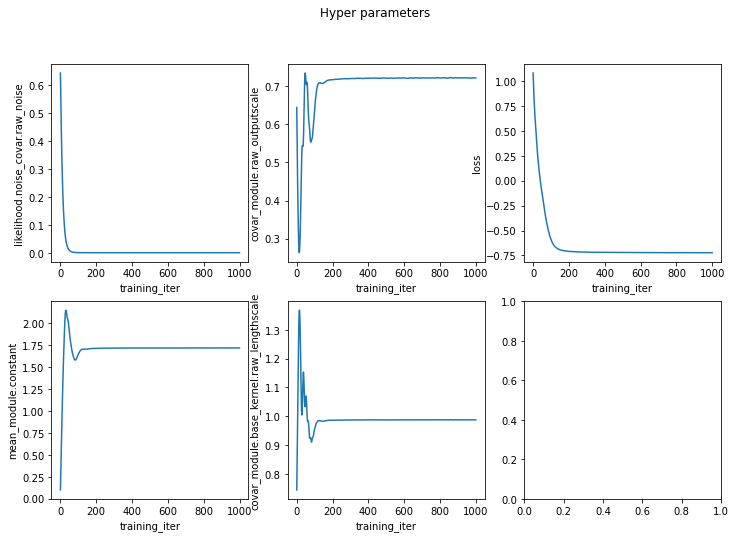

dict_keys(['likelihood.noise_covar.raw_noise', 'mean_module.constant', 'covar_module.raw_outputscale', 'covar_module.base_kernel.raw_lengthscale', 'loss'])


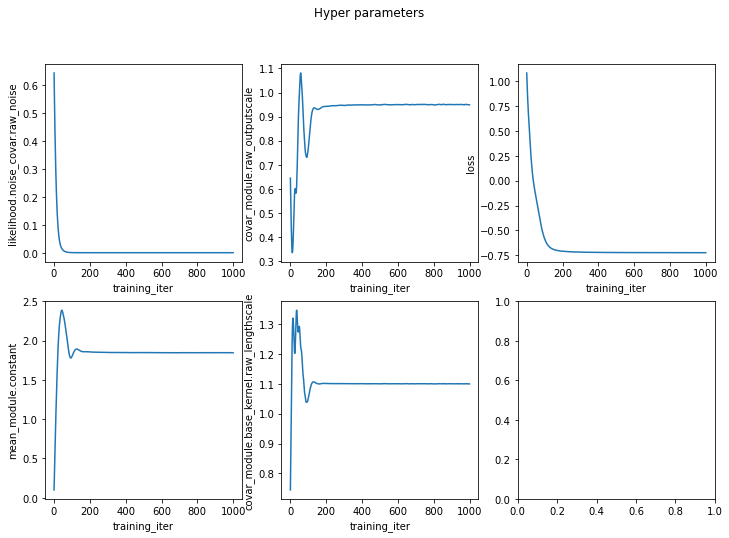

 40%|█████████████████▌                          | 4/10 [01:08<01:42, 17.08s/it]

dict_keys(['likelihood.noise_covar.raw_noise', 'mean_module.constant', 'covar_module.raw_outputscale', 'covar_module.base_kernel.raw_lengthscale', 'loss'])


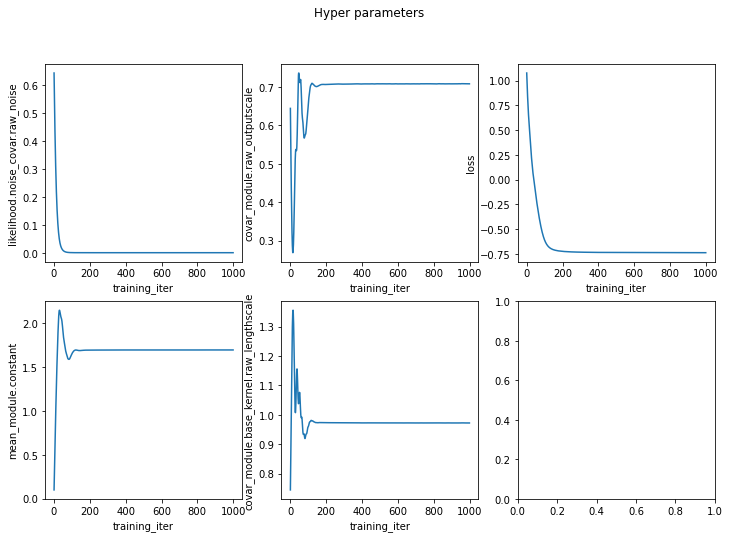

dict_keys(['likelihood.noise_covar.raw_noise', 'mean_module.constant', 'covar_module.raw_outputscale', 'covar_module.base_kernel.raw_lengthscale', 'loss'])


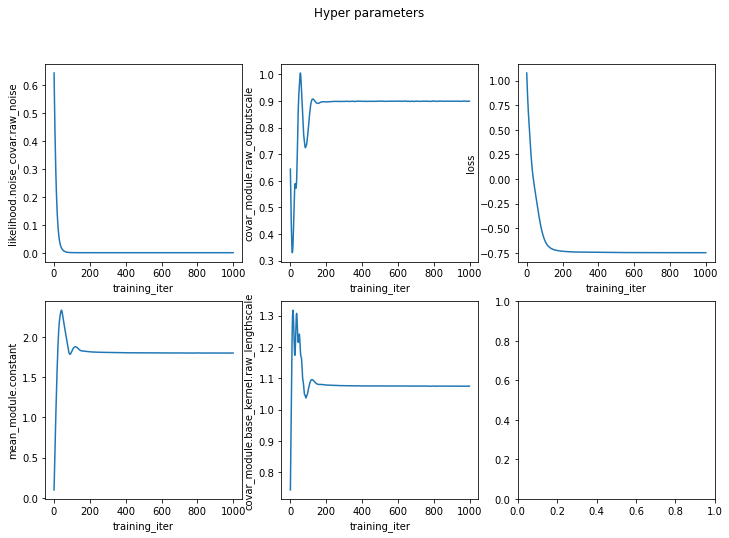

 50%|██████████████████████                      | 5/10 [01:27<01:29, 17.96s/it]

dict_keys(['likelihood.noise_covar.raw_noise', 'mean_module.constant', 'covar_module.raw_outputscale', 'covar_module.base_kernel.raw_lengthscale', 'loss'])


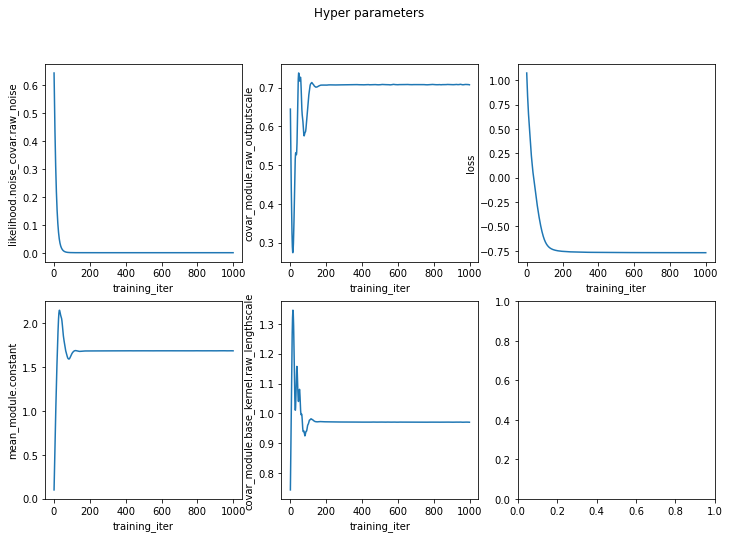

dict_keys(['likelihood.noise_covar.raw_noise', 'mean_module.constant', 'covar_module.raw_outputscale', 'covar_module.base_kernel.raw_lengthscale', 'loss'])


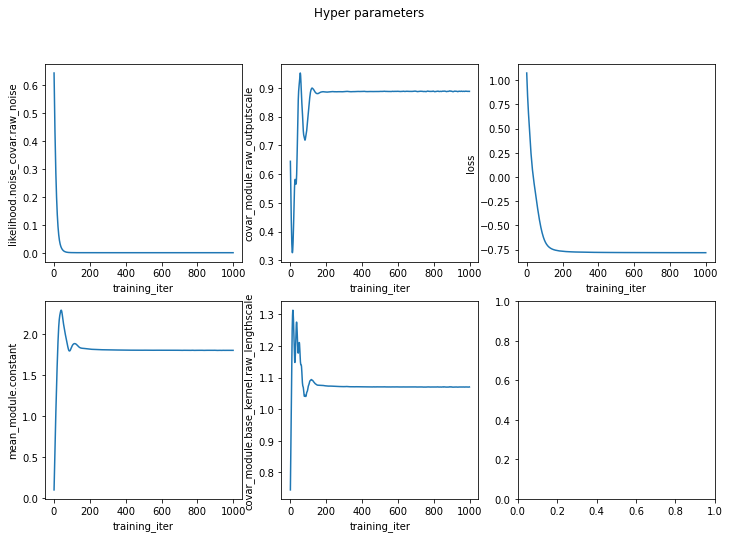

 60%|██████████████████████████▍                 | 6/10 [01:45<01:11, 17.89s/it]

dict_keys(['likelihood.noise_covar.raw_noise', 'mean_module.constant', 'covar_module.raw_outputscale', 'covar_module.base_kernel.raw_lengthscale', 'loss'])


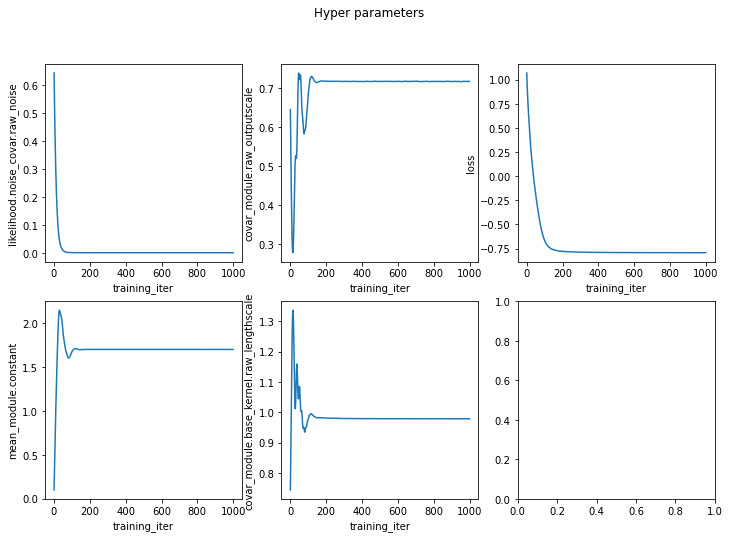

dict_keys(['likelihood.noise_covar.raw_noise', 'mean_module.constant', 'covar_module.raw_outputscale', 'covar_module.base_kernel.raw_lengthscale', 'loss'])


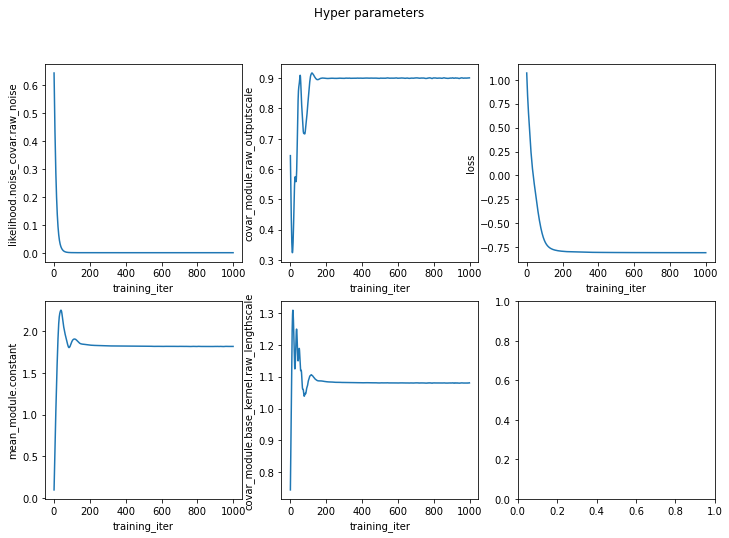

 70%|██████████████████████████████▊             | 7/10 [02:04<00:54, 18.32s/it]

dict_keys(['likelihood.noise_covar.raw_noise', 'mean_module.constant', 'covar_module.raw_outputscale', 'covar_module.base_kernel.raw_lengthscale', 'loss'])


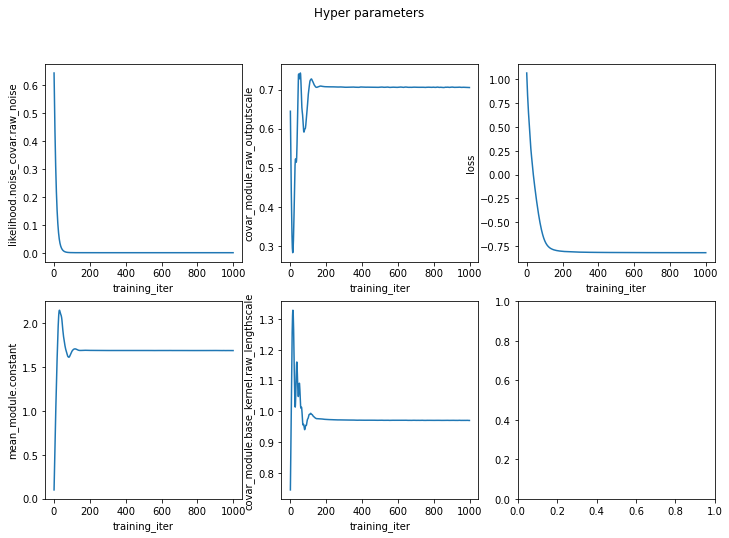

dict_keys(['likelihood.noise_covar.raw_noise', 'mean_module.constant', 'covar_module.raw_outputscale', 'covar_module.base_kernel.raw_lengthscale', 'loss'])


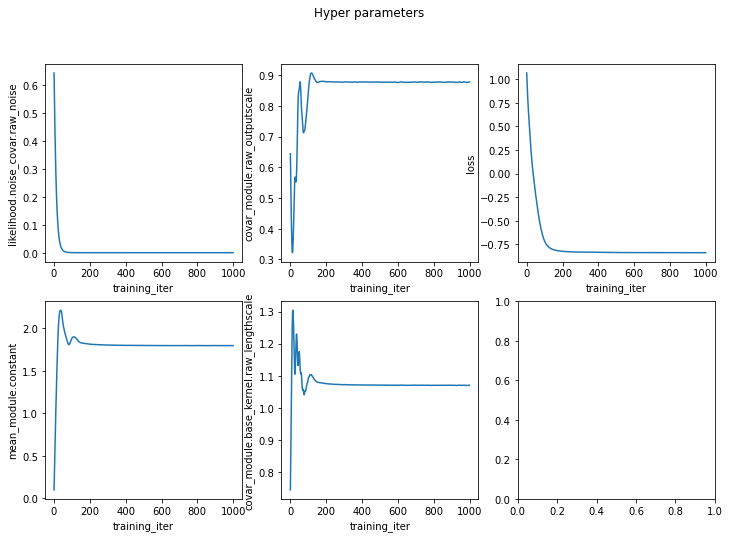

 80%|███████████████████████████████████▏        | 8/10 [02:24<00:37, 18.71s/it]

dict_keys(['likelihood.noise_covar.raw_noise', 'mean_module.constant', 'covar_module.raw_outputscale', 'covar_module.base_kernel.raw_lengthscale', 'loss'])


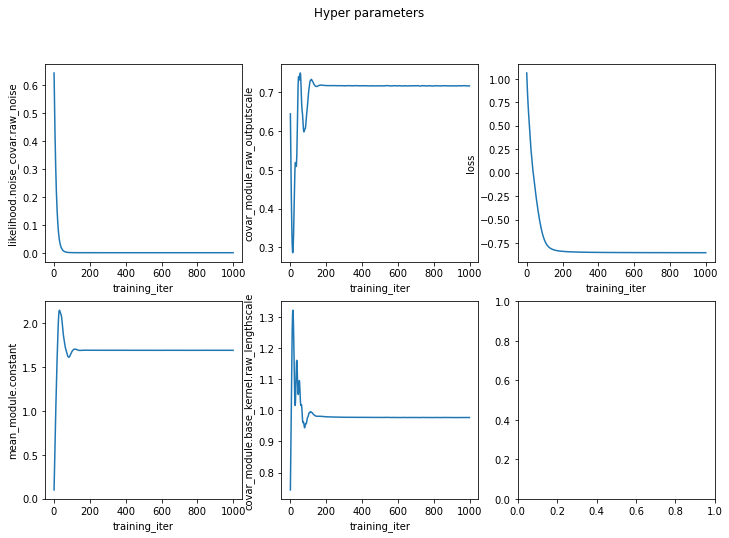

dict_keys(['likelihood.noise_covar.raw_noise', 'mean_module.constant', 'covar_module.raw_outputscale', 'covar_module.base_kernel.raw_lengthscale', 'loss'])


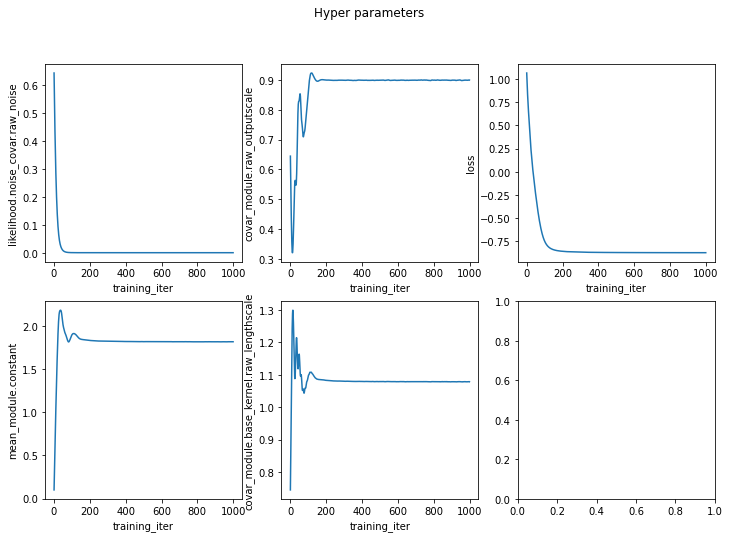

 90%|███████████████████████████████████████▌    | 9/10 [02:43<00:18, 18.85s/it]

dict_keys(['likelihood.noise_covar.raw_noise', 'mean_module.constant', 'covar_module.raw_outputscale', 'covar_module.base_kernel.raw_lengthscale', 'loss'])


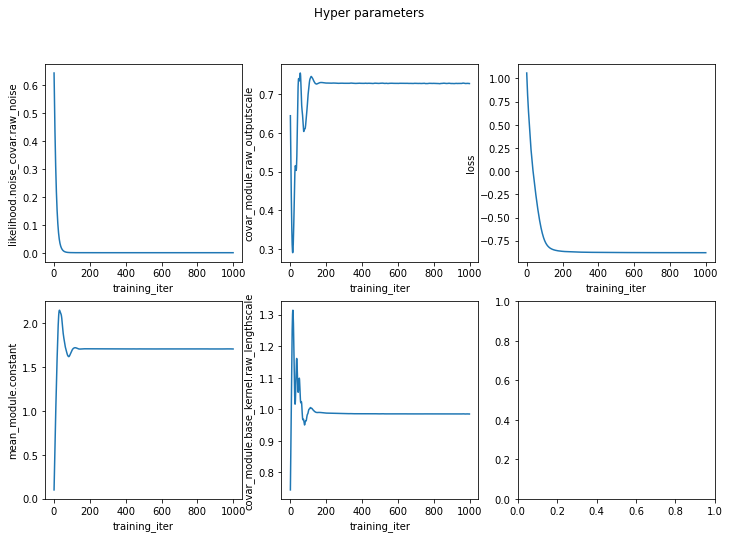

dict_keys(['likelihood.noise_covar.raw_noise', 'mean_module.constant', 'covar_module.raw_outputscale', 'covar_module.base_kernel.raw_lengthscale', 'loss'])


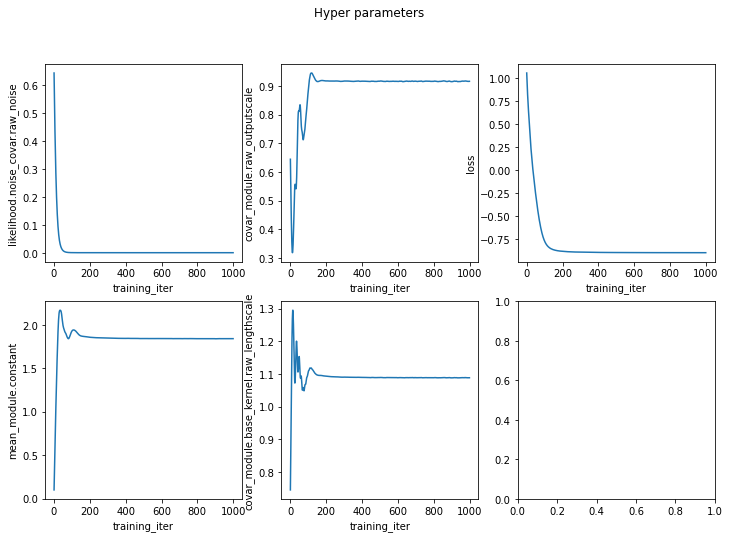

100%|███████████████████████████████████████████| 10/10 [03:03<00:00, 18.34s/it]


In [38]:
for weight in weights:
    for _ in tqdm(range(int((max_iter-number_designs)/len(weights)))):
        models = train_model()

        def prediction(x: np.ndarray) -> np.ndarray:
            x = torch.Tensor([x.tolist()])
            return np.array([model.predict_torch(x).mean.numpy()[0] for model in models])


        def std(x: np.ndarray) -> np.ndarray:
            x = torch.Tensor([x.tolist()])
            return np.array([model.predict_torch(x).stddev.numpy()[0] for model in models])


        res = differential_evolution(
                func=lambda x: weight_function(prediction(x)*weight),
                x0=np.array([0.5 for _ in range(input_dimensions)]),
                tol=1e-5,
                bounds=[
                    (0, 1) for _ in range(input_dimensions)
                ],
                maxiter=100,
            )

        input_parameters = np.append(input_parameters,res.x.reshape(1,input_dimensions),axis=0)
        output_parameters = np.append(output_parameters,function(res.x).reshape(1,2),axis=0)


In [39]:
PF = return_pareto_front(output_parameters)

In [40]:
data = [go.Scatter(x=output_parameters.T[0],y=output_parameters.T[1],mode="markers"),
        go.Scatter(x=PF.T[0],y=PF.T[1],mode="markers"),
        go.Scatter(x=real_PF.T[0],y=real_PF.T[1],mode="markers"),
       ]

fig = go.Figure(data=data)
fig.show()

In [41]:
data = [go.Scatter(x=output_parameters.T[0][:number_designs],y=output_parameters.T[1][:number_designs],mode="markers"),
        go.Scatter(x=output_parameters.T[0][number_designs:],y=output_parameters.T[1][number_designs:],mode="markers"),
       ]

fig = go.Figure(data=data)
fig.show()

In [42]:
hypervolume_max

3.210130351468824

In [43]:
hypervolume_weight = metric.do(PF)
hypervolume_weight /hypervolume_max

0.9453317931143214